# Hito 1 - AppEval

CC5205 - Minería de Datos

- Profesora: Jazmine Maldonado
- Auxiliar: Fran Zautzik

Integrantes:
- Felipe Avendaño
- Martín Bravo
- Franco González
- Daniel Radrigán
- Felipe Valdebenito

## 1. Introducción

En la actualidad, las redes sociales constituyen una de las principales formas de comunicación en el mundo. Algunas de estas redes concentran una cantidad tan grande de personas que las usan, que una alternativa a ellas suena como algo impensable. Aún así, algunas corporaciones lanzan su perspectiva de como debiese ser alguna red social en cuestion (séase de ejemplo, la existencia de Telegram frente a WhatsApp como aplicaciones de mensajería instantánea). Dichas redes han sido desarrolladas en base a estudios de mercado, análisis de información, y para este caso, se mencionara el feedback otorgado directamente por los usuarios que conforman la plataforma en sí.

Comercialmente hablando, la retroalimentación de los usuarios sobre una determinada aplicación es determinante a la hora de realizar mejoras que atraigan y retengan usuarios dentro de la misma plataforma. Tomando esto en cuenta, dada la gran cantidad de comentarios negativos con descripciones vagas o de exagerada negatividad, se complejiza el poder obtener un feedback objetivo que indique precisamente las falencias de la app. Por estas razones, poder extraer determinados fragmentos que se frecuentan en comentarios negativos es de importancia para ayudar a las empresas a mantener la calidad de sus aplicaciones.

A raíz de ello, nuestro objetivo es plantear una forma de extraer información a partir de las reseñas de aplicaciones, donde, usando los datos extraídos, se busca dar solución a, por ejemplo, la efectividad para resolver errores en una aplicación que mencionen los usuarios por medio de los comentarios. Con ello, además, se busca aportar en la importancia de la opinión del usuario frente al producto que usa, recalcando que, como cliente de una aplicación, es un usuario activo a la hora de mantener viva una comunidad conformada tanto por personas comunes como por los gestores de la aplicación.

Los datos que se usarán en el proyecto a presentar, corresponden a reviews de usuarios de aplicaciones de redes sociales, en particular, la aplicación Threads. El estudio de estos datos puede permitir el observar que aspectos de las aplicaciones valoran los usuarios. Tambien permite entender las razones del porque no gusta determinada característica. La elección de datos se basa en la relevancia que poseen para el desarrollo de nuevas redes sociales o mejoras de las ya existentes.

Para las empresas, es de particular interés el uso de técnicas de mineria de datos para obtener los aspectos criticados en las reviews de la app, esto a partir del análisis del lenguaje empleado (es decir, como el uso del lenguaje con sustantivos, adjetivos, verbos, etc. aporta a una visión general de como establecer parámetros de una opinión).

Como bien se ha mencionado, estudiar estos datos nos permite entender cuales son los aspectos a mejorar de una app, los cuales no pueden ser conocidos mediante una simple puntuación numérica (e.g. 1-5 estrellas), pues solo indica el nivel de satisfacción que el usuario tiene sobre la app, sin otorgar detalle sobre la razón de dicha calificación.

## 2. Exploración de Datos

Por medio del uso de Python, junto con variadas librerias para la manipulación del dataset escogido, se procedera a la obtención de tablas y gráficos para extraer información general sobre los comentarios dados a la aplicación Threads. Dicha aplicación se basa en la publicación de mensajes breves a modo de que cada usuario participa en "foros" según los tópicos más importantes del día.

In [1]:
# Librerías

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import string # string manipulation
import re # regular expressions
import nltk # text manipulation
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import trange # progress bar
from nltk import tokenize # text manipulation
from nltk.corpus import stopwords # text manipulation
from nltk.stem import WordNetLemmatizer # text manipulation
from nltk.probability import FreqDist # text manipulation
from collections import Counter # text manipulation
from sklearn.feature_extraction.text import CountVectorizer # text manipulation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # wordcloud generator
from IPython.display import display # image display
from PIL import Image

#hito 2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from datasets import load_dataset
import joblib # guardar modelos

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En primer lugar se mostrará una vista preliminar del dataset escogido. Para ver cantidad de columnas y los tipos de datos que se manejan:

In [2]:
data = pd.read_csv("threads.csv") # carga del dataset a usar como variable
data.head(10)

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
5,Google Play,"Currently, it's very challenging to use. It's ...",2,2023-07-18 22:30:10
6,Google Play,I still don’t want to see content from people ...,1,2023-07-19 19:35:31
7,Google Play,Could be great if all pages loaded when you cl...,2,2023-07-06 14:35:15
8,Google Play,I'm liking the concept! There is room for impr...,3,2023-07-09 03:27:39
9,Google Play,Not bad! This is its first launch. There is st...,5,2023-07-06 23:41:13


Dicho dataset cuenta con 4 columnas, y 32910 filas. Las columnas son:
- Source: La procedencia de los comentarios (según el sistema operativo y la tienda de aplicaciones de la cual se descargó),
- Review Description: El comentario publicado, el cual contiene el detalle sobre la calificación otorgada a la aplicación.
- Rating: La puntuación otorgada, en una escala de 1 a 5, con 1 como puntuacion mala y 5 como excelente.
- Review Date: Fecha de publicación de la reseña, con detalle sobre el día, mes, año y hora de publicación.

Se hará una revisión a la cantidad de reseñas segun la calificación otorgada:

In [3]:
print(data["rating"].value_counts()) # contar la cantidad de reviews recibidas segun el rating de 1 a 5

# muestra mediana, media, desviación estándar, mínimo y máximo de la variable "replies"
data.describe()

rating
5    15559
1     9726
4     3244
3     2585
2     1796
Name: count, dtype: int64


,rating
count,32910.000000
mean,3.398481
std,1.751480
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


Se puede ver que el promedio de los ratings es de 3.4, lo cual es un valor bastante bajo. Además, se observa que la mayoría de reseñas son de 5 estrellas, y luego vienen las de 1 estrella. Esto nos sugiere dividir las reseñas en distintos grupos.

A partir de estos datos, se puede generar un gráfico de pastel. Primero, se realizará una conversión del rating según rangos. Dichos rangos son: 1-2 estrellas como NEGATIVO, 3-4  estrellas como NEUTRAL y 5 estrellas como POSITIVO. El gráfico generado se muestra a continuación.

La razón de esta elección es debido a que los comentarios de 1-2 estrellas suelen ser de tipos negativos, mientras que los de 5 estrellas suelen ser positivos. Los comentarios de 3-4 estrellas se considerarán como neutrales, ya que dicen algo positivo de la aplicación, pero también mencionan algo negativo (en un principio se dejó neutral como 3 estrellas pero esto generaba muy poca cantidad de reseñas neutrales).

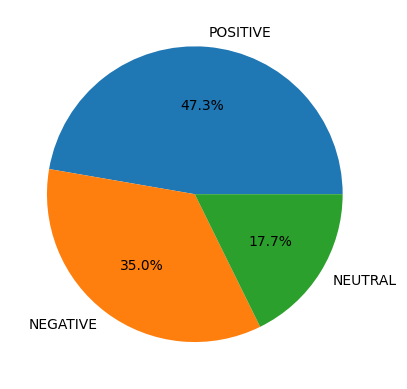

In [4]:
# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating <= 4:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)
plt.pie(data["rating"].value_counts(), labels=data["rating"].value_counts().index, autopct='%1.1f%%')
plt.show()

Se puede ver que la mayoría de las reseñas son positivas, siguiendo en cantidad las negativas y por último las neutrales. Esto sugiere que la aplicación se considera buena, pero tiene algunos problemas que se pueden mejorar.

Ya que nuestro dataset contiene en su mayoría texto, se generarán columnas que ayudarán a analizarlo. Estas columnas serán:
- Review Length: Largo del comentario.
- Word Count: Cantidad de palabras que contiene el comentario.
- Mean Word Length: Promedio de largo de las palabras del comentario.
- Mean Sentence Length: Promedio de largo de las oraciones del comentario.

Estas columnas apoyarán en la realización de gráficos basados en atributos provenientes del texto.

In [3]:
# tabla generada con el largo en caracteres de las reviews escritas
data['Length'] = data['review_description'].str.len()
# numero de palabras en la primera review del dataset
word_count = data['review_description'][0].split()
# funcion para separar una oracion y contar la cantidad de palabras que posee
def word_count(review):
    review_list = review.split()
    return len(review_list)
# generacion de nueva columna de cantidad de palabras por review
data['Word_count'] = data['review_description'].apply(word_count)
# largo promedio de las palabras en cada review
data['mean_word_length'] = data['review_description'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
# largo promedio de las oraciones en cada review
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['review_description'][0])])
data['mean_sent_length'] = data['review_description'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

data.head(10)

,source,review_description,rating,review_date,Length,Word_count,mean_word_length,mean_sent_length
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,465,85,4.482353,65.571429
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,475,81,4.876543,157.666667
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,497,91,4.472527,70.142857
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,487,94,4.191489,80.333333
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,426,79,4.405063,84.400000
5,Google Play,"Currently, it's very challenging to use. It's ...",2,2023-07-18 22:30:10,386,75,4.160000,47.375000
6,Google Play,I still don’t want to see content from people ...,1,2023-07-19 19:35:31,438,81,4.419753,86.800000
7,Google Play,Could be great if all pages loaded when you cl...,2,2023-07-06 14:35:15,365,67,4.462687,60.000000
8,Google Play,I'm liking the concept! There is room for impr...,3,2023-07-09 03:27:39,416,86,3.848837,40.700000
9,Google Play,Not bad! This is its first launch. There is st...,5,2023-07-06 23:41:13,328,55,4.981818,46.000000


A partir de la tabla anterior, se pueden extraer los siguientes gráficos, cada uno basado en cada una de las columnas creadas:

['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']



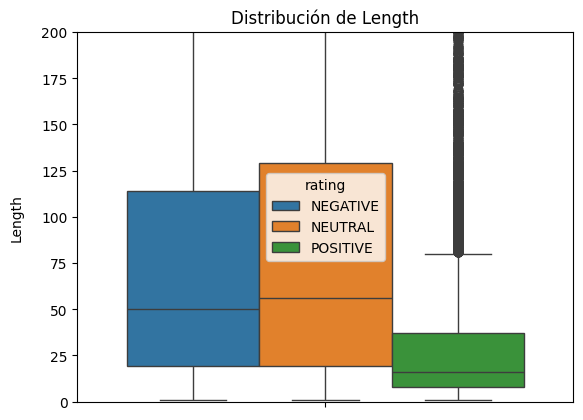

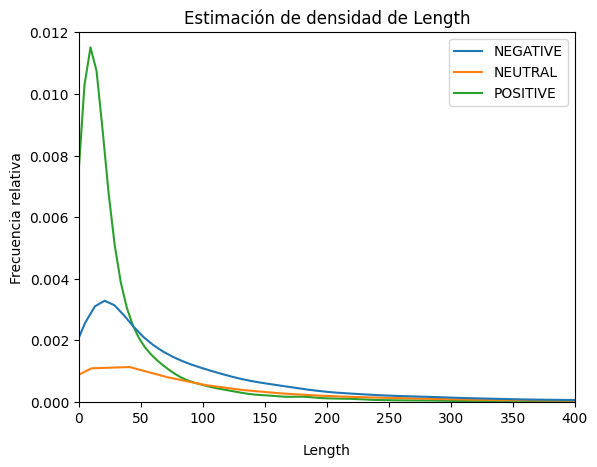

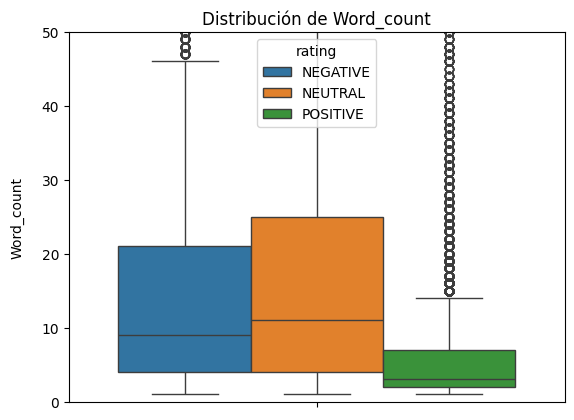

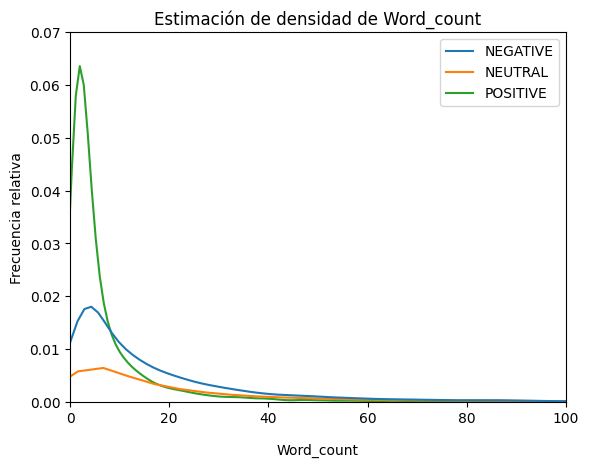

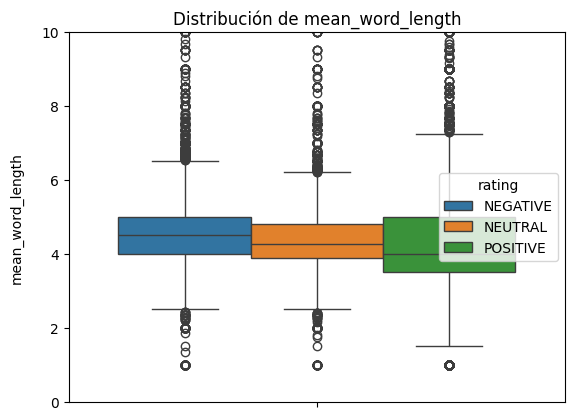

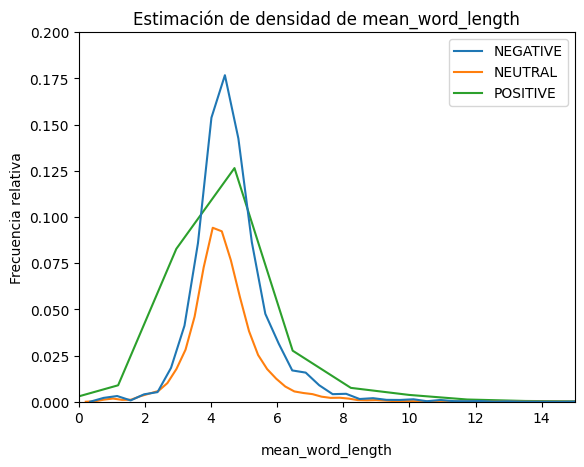

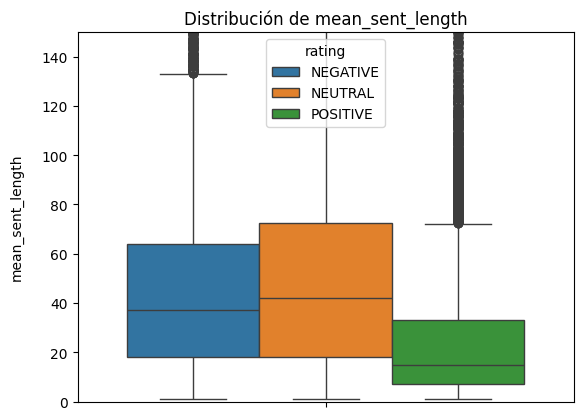

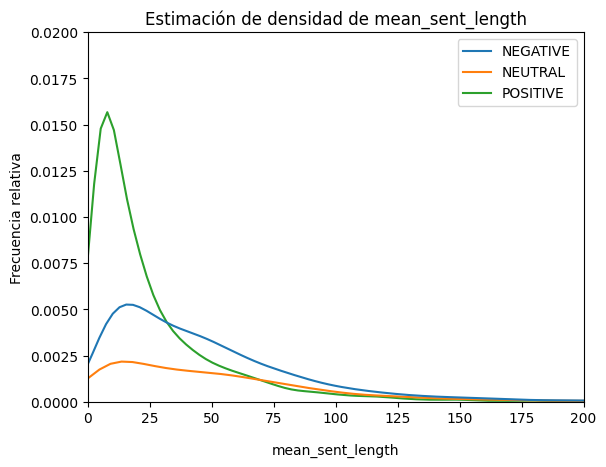

In [6]:
# creacion del boxplot de las palabras
def visualize(col, ind=0, max_ys_k=[0.012,0.07,0.2,0.02], max_xs_k=[400,100,15,200], max_ys_b =[200,50,10,150]):

    print()
    plt.plot(1,2,1)
    sns.boxplot(y=data[col], hue=data['rating'])
    plt.title('Distribución de '+col)
    plt.ylabel(col, labelpad=12.5)
    plt.ylim(0,max_ys_b[ind])
    plt.show()

    plt.plot(1,2,2)
    sns.kdeplot(data=data, x=col, hue='rating')
    plt.legend(data['rating'].unique())
    plt.ylim([0,max_ys_k[ind]])
    plt.xlim([0,max_xs_k[ind]])
    plt.title('Estimación de densidad de '+col)
    plt.xlabel(col, labelpad=12.5)
    plt.ylabel('Frecuencia relativa')



    plt.show()

features = data.columns.tolist()[4:]
print(features)
i = 0
for feature in features:
    visualize(feature,ind=i)
    i+=1

**Observaciones con respecto a los gráficos:**

- Review Length:

La mayoria de los largos de los comentarios son menores a 75 caracteres, es decir, los comentarios suelen ser cortos, en especial los comentarios positivos. Podemos notar que mientras los comentarios positivos suelen ser cortos, los comentarios neutrales estan más equilibrados y los comentarios negativos también, aunque estos últimos también tiene una alta frecuencia de comentarios cortos.

Por lo anterior, se puede decir que los comentarios con mayor información deberian ser aquellos que muestran descontento por la aplicación, probablemente por que en su comentario hablan del problema que tienen con la aplicación, mientras que comentarios más positivos puede ser que solo destaquen aquello que les gusta sin necesidad de extenderse mucho en el porque.

- Word Count:

Las conclusiones anteriores también se extienden a la cantidad de palabras utilizadas en el comentario, ya que estan muy relacionados. La frecuencia de la cantidad de palabras también esta concentrada en valores bajos y se comporta igual que el largo con respecto a comentarios positivos, neutrales y negativos.

- Mean Word Length:

Podemos observar que el largo promedio de las palabras utilizadas pareciera seguir una distribucion normal, lo cual tine relación con las palabras que se utilizan para escribir las reseñas, que una reseña tenga un largo de palabras muy alto indicaría la utilización de un lenguaje más técnico y complicado, en cambio aquellos comentarios con promedios de palabras mas cortos problablemente utilizan muchas palabras que aportan poco al mensaje.

También podemos notar que en general los comentarios positivos estan mas distribuidos en cuanto al largo promedio de las palabras, en cambio los comentarios negativos se concentran mucho más en torno al valor promedio.

- Mean Sentence Length:

Con respecto al largo promedio de las oraciones de los comentarios podemos ver que en general también se concentran en valores bajos, pero esto es mas notorio para los comentarios positivos que probablemente solo destacan lo positivo de la aplicación mientras que los neutrales y los negativos estan más distribuidos y tienen mayor frecuencia en valores más grandes, problablemente porque muestran su descontento o describen su problema con la aplicación, lo cual los puede llevar a escribir un comentario más largo y complejo.

### Analisis de frecuencia de términos

Se hará uso de la librería NLTK, la cual permite realizar un análisis de frecuencia de términos. Para esto, primero se debe limpiar el texto, eliminando signos de puntuación, números, stopwords, etc. Esto se realiza gracias a que internamente NLTK posee una lista de stopwords en inglés, la cual se usará para eliminarlas. Además, se hará uso de la librería string para eliminar signos de puntuación y números.

In [7]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

data['review_description'] = data['review_description'].apply(clean)

Posterior a la limpieza, se procede a incluir las palabras generadas a una lista, con la cual se extraerán las 10 palabras más comunes dentro de todas las reseñas. A continuación, se muestra un gráfico con los resultados obtenidos, conteniendo el Top 10 de palabras más comunes.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32910/32910 [00:00<00:00, 263265.44it/s]


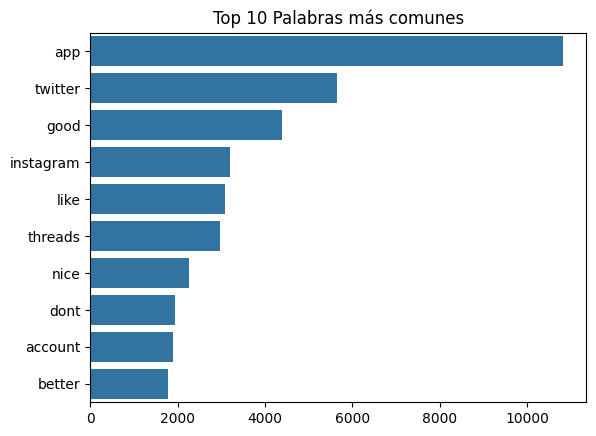

In [8]:
def corpus(text):
    text_list = text.split()
    return text_list

data['review_lists'] = data['review_description'].apply(corpus)

corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['review_lists'][i]

mostCommon = Counter(corpus).most_common(10)

words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Palabras más comunes')
plt.show()

Con respecto a las palabras más comunes, es dificil concluir algo acerca, ya que no se tiene el contexto en el que se están utilizando. Aún asi, se pueden extraer algunos detalles, mencionados a continuación:

- Que tanto "app" como "instagram" estén entre las palabras más frecuentes no es extraño, ya que hacen referencia a la propia aplicación sobre la cual trata el comentario.

- Una palabra que resulta extraña respecto a que sea tan común es "twitter". Esto probablemente está relacionado con el hecho de que la aplicación nombrada es "la competencia", por lo que los usuarios siempre van a hacer comparaciones para decir si una aplicación es mejor o peor a otra. En este caso, no podemos identificar el contexto en el que se utiliza la palabra "twitter" pero podemos suponer que se utiliza para decir que instagram es peor o mejor que "twitter" en alguna de sus características.

- Otras palabras como "good", "like", "nice" y "better" probablemente son parte de comentarios positivos, aunque no significa que no puedan estar en uno neutral o negativo. Estas palabras también son bastante comunes y son de un uso muy general. Además, los comentarios positivos representan gran parte del data set, por lo estan palabras no nos aportan información relevante del todo.

- Otra palabra comun es "dont", pero esta palabra es de un uso muy general asi que no sorprende que sea frecuente. Además, no podemos interpretar el contexto en el que se utiliza, ya que "dont" podría ser utilizado tanto para un comentario positivo, como negativo. Aún así, uno podría pensar que la palabra estaría más relacionada con comentarios negativos y podrá relacionarse con algo que quizá no les gusta a los usuarios o no les funciona a la hora de usarlo.

- Las palabras "threads" y "account" hacen referencia a características de la aplicación. Es difícil concluir algo, ya que el comentario puede ser positivo o negativo. Lo único que podemos decir, es que el comentario probablemente es más extenso en su contenido al estar hablando de algún tema en específico de la aplicación.



---



También, posterior a la limpieza, es posible generar nubes de palabras basadas en la cantidad de palabras por Rating, esto nos permitira un mejor análisis de las palabras frecuentes ya que tendremos un mayor contexto para poder realizar el anáisis. Los Wordclouds que se pudieron extraer son los siguientes:

In [10]:
# generacion de la wordcloud para definir cuales pueden ser las palabras mas importantes
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

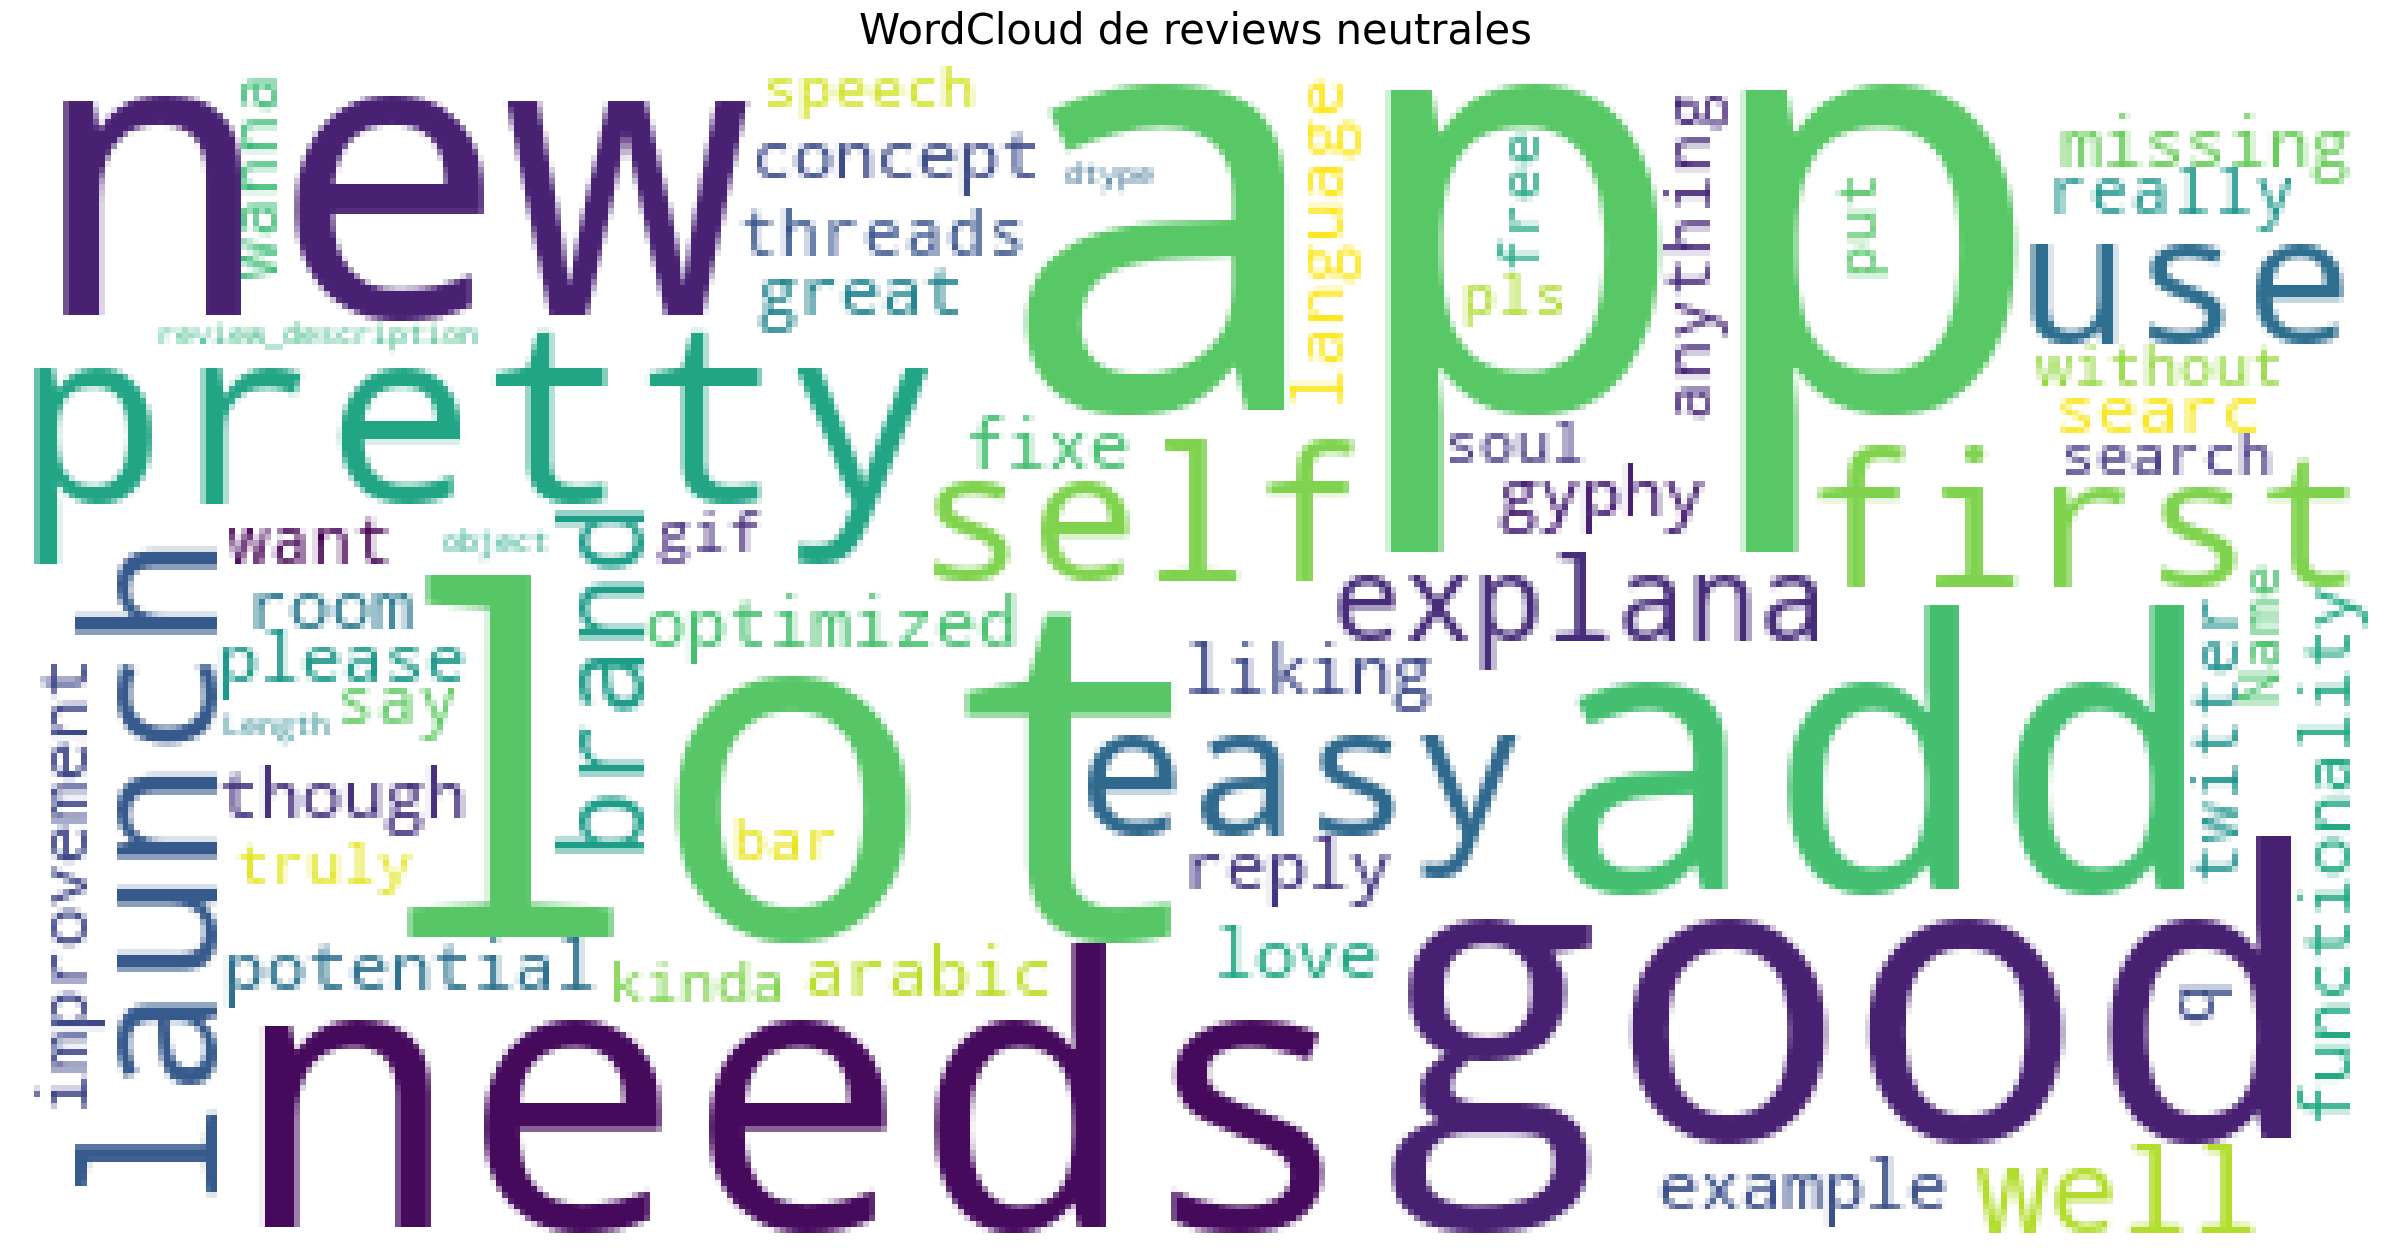

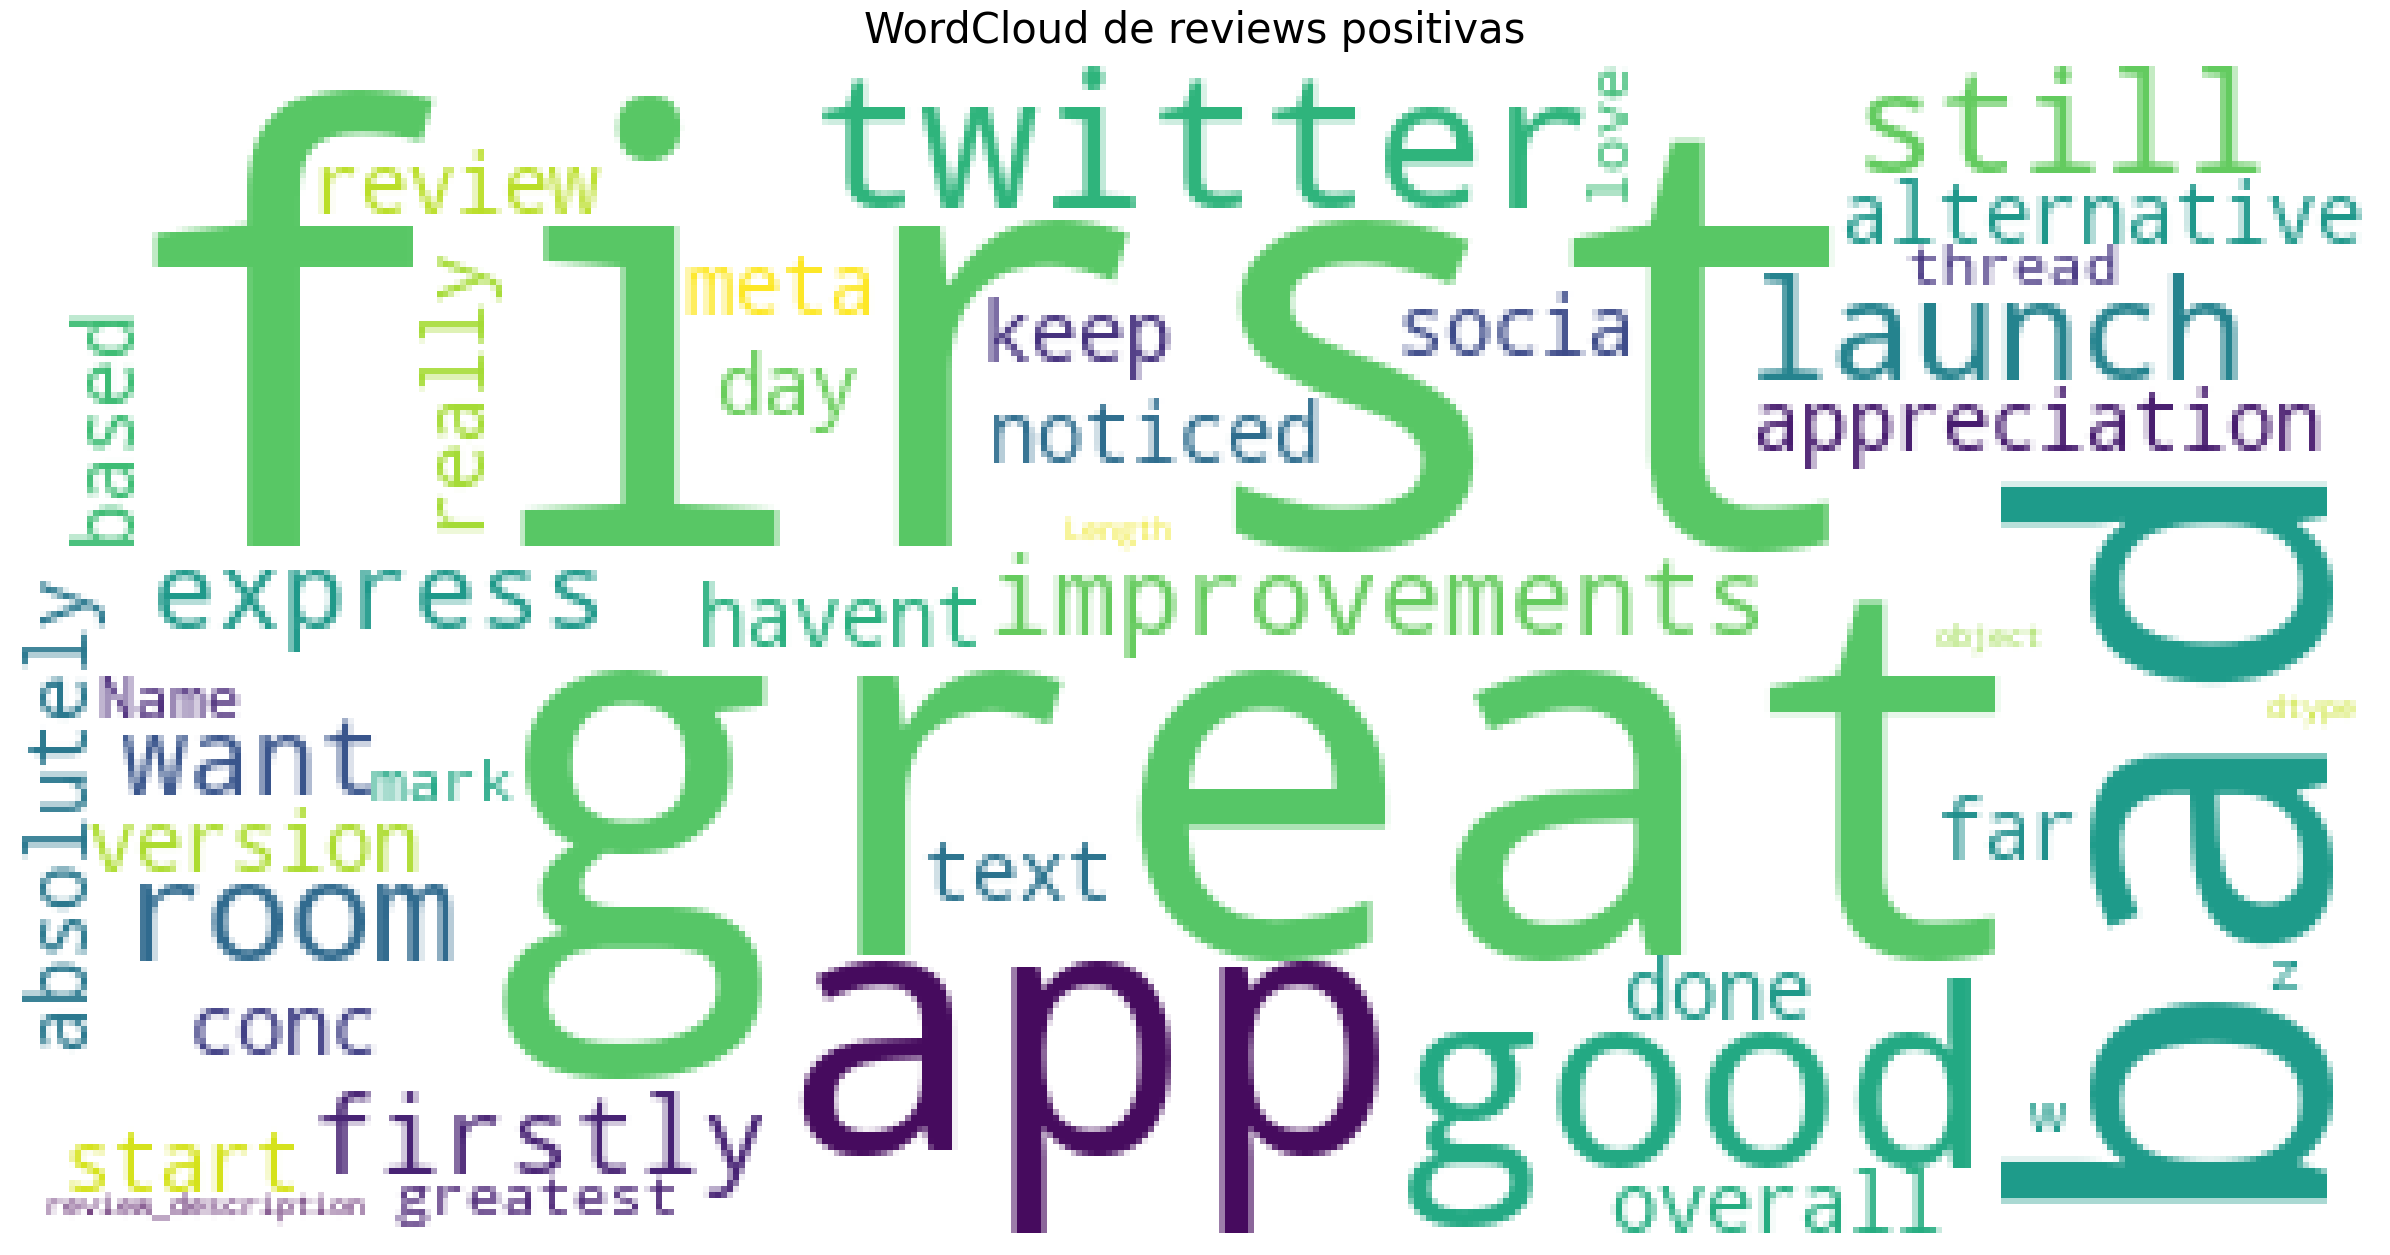

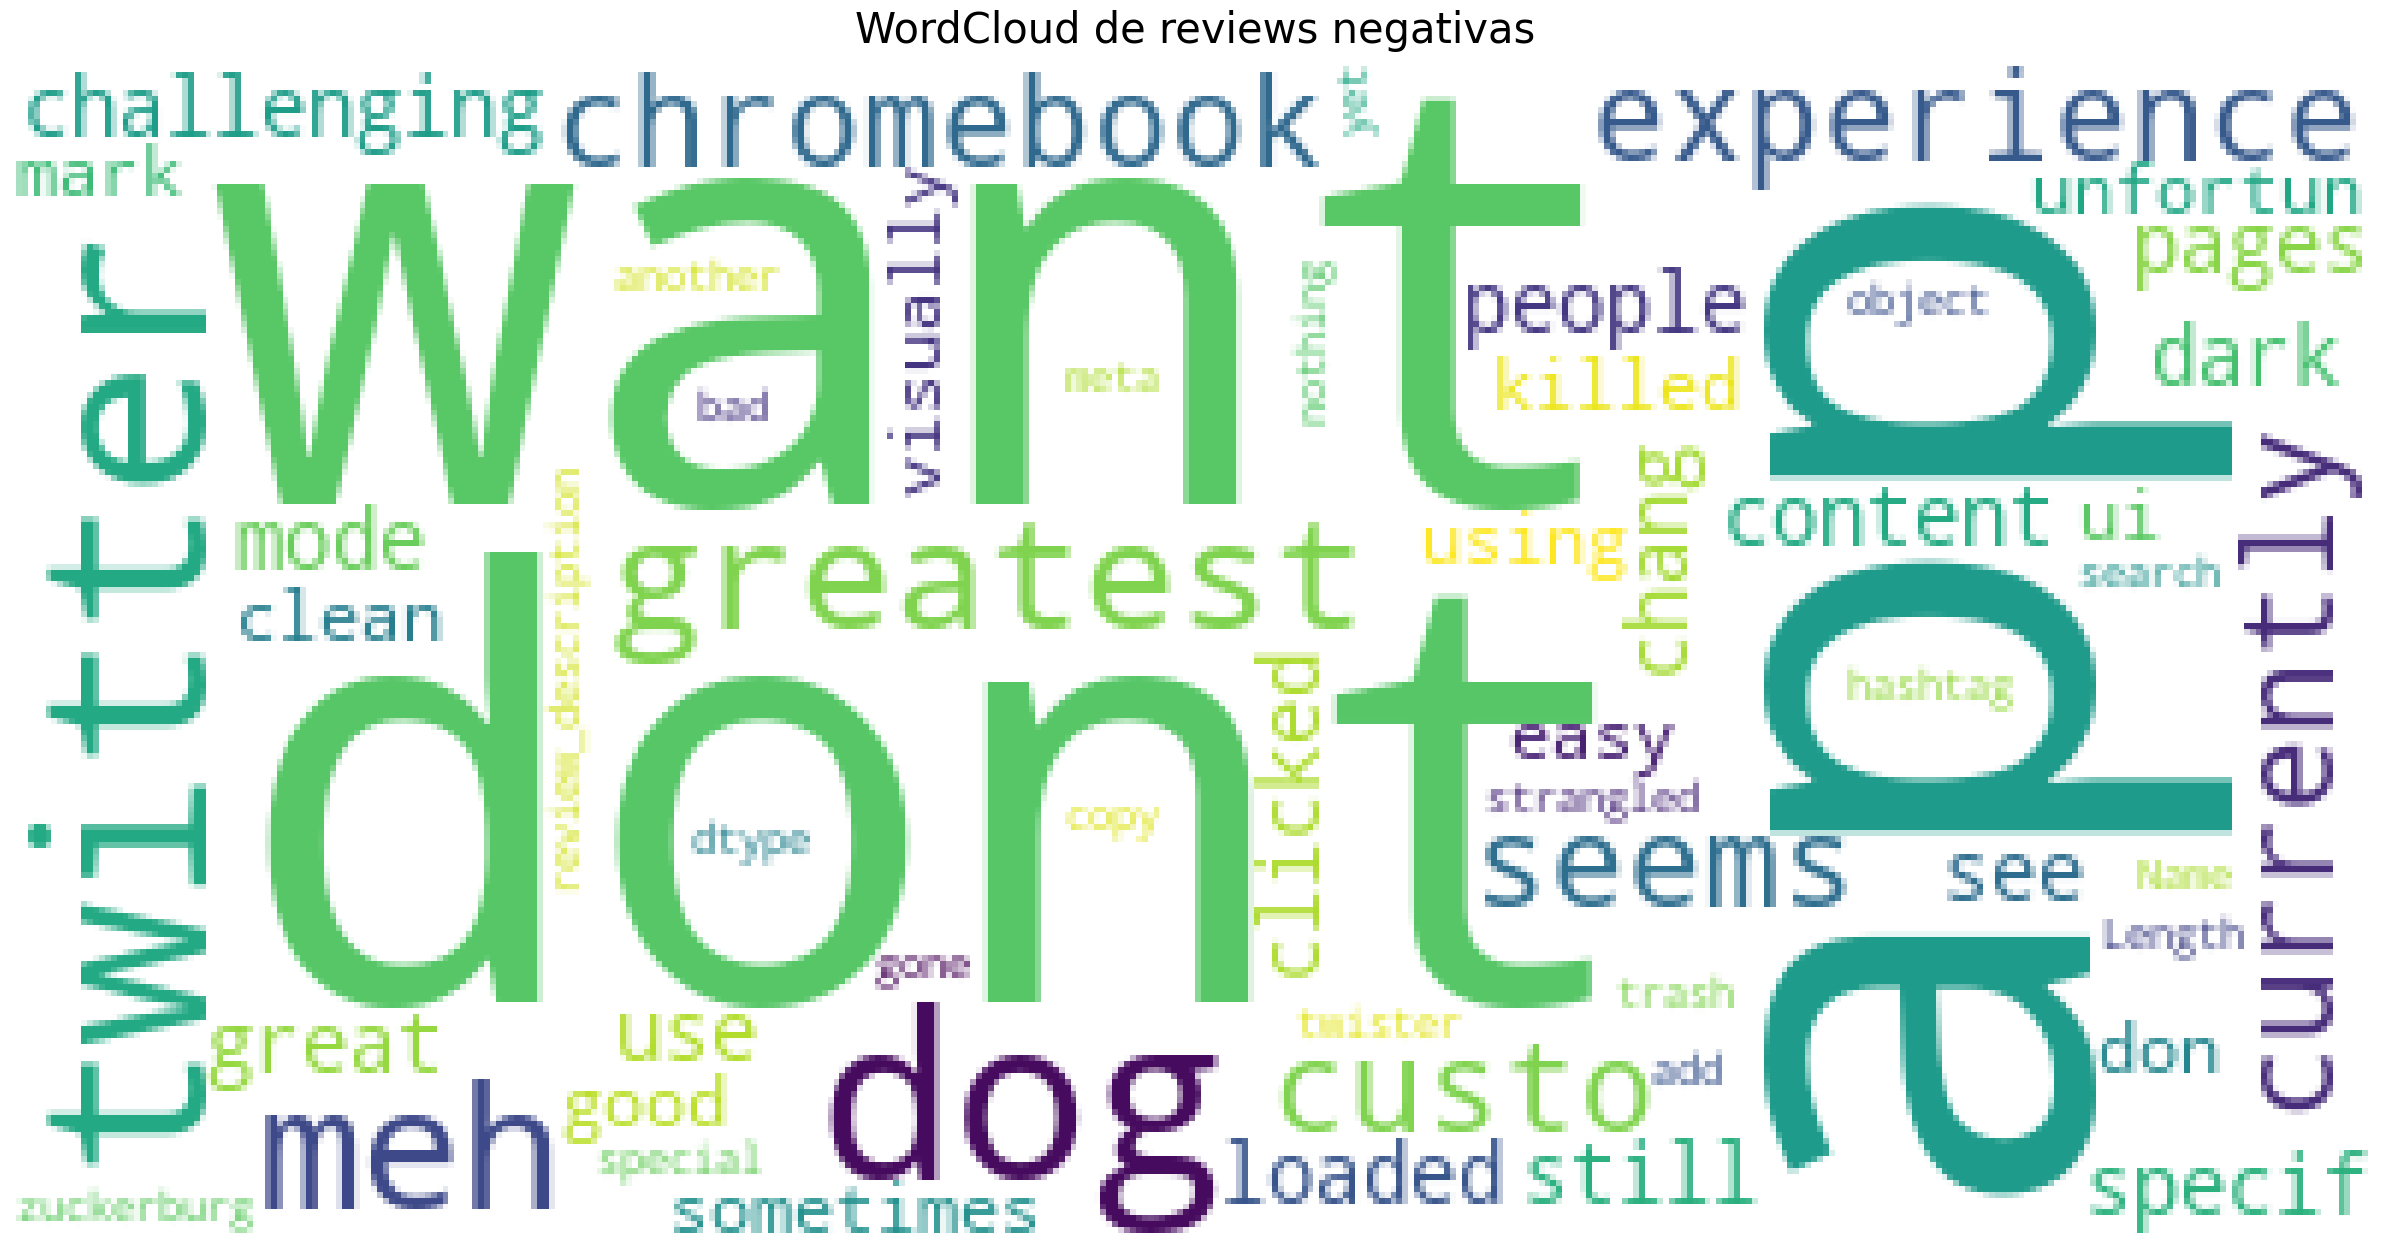

In [11]:
Neutral_rev = data[data["rating"] == "NEUTRAL"]
plot_wordcloud(Neutral_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews neutrales")
Posit_rev = data[data["rating"] == "POSITIVE"]
plot_wordcloud(Posit_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews positivas")
Neg_rev = data[data["rating"] == "NEGATIVE"]
plot_wordcloud(Neg_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews negativas")

### Los $N-$ gramas mas frecuentes

Los $N-$ gramas son secuencias de $N$ palabras consecutivas en un texto. Estos nos permitirán dar un mayor contexto a las palabras con mayor frecuencia recién vistas. A continuación veremos los 10 $2-$ gramas y $3-$ gramas más frecuentes.

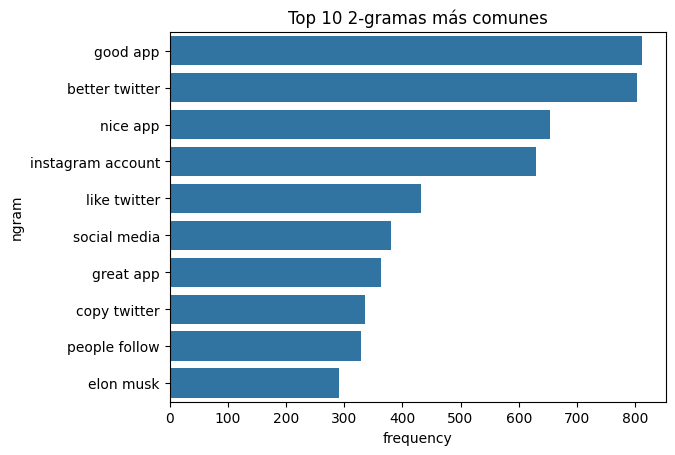

In [9]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['review_description'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 2-gramas más comunes')
plt.show()

El 2-grama nos permite complementar la información anterior y tener un mayor contexto ya ahora son grupos de palabras y no palabras sueltas. Esto nos permite obtener mejores conclusiones con respecto a palabras mas frecuentes. Por ejemplo, podemos ver que en general "good" va seguido de "app", lo cual refuerza algunas de las cosas dichas anteriormente como que las reseñas positivas van dirigidas a temas mas generales y no tanto a un problemas más específico. También vemos que esta "better twitter" o "copy twitter", lo cual también refuerza parte de lo dicho anteriormente ya que estos comentarios, problablemente negativos, comparan la aplicación con twitter y valora una aplicación por sobre la otra. 

Otros comentarios siguen sin tener mucho sentido al no tener contexto, como "social media", frase que tiene mucha relación con la aplicación pero es no se puede decir con certeza si se esta utilizando en un contexto positivo, negativo o neutral. El tener a "elon musk" como 2-grama frecuente probablemente se relaciona con la rivalidad entre aplicaciones y todos los eventos recientes con respecto a Elon Musk y la compra de twitter, lo cual provocó un aumento significativo en los comentarios con respecto a ese tema.

Se mostrará lo obtenido con 3-gramas, siendo las frases de tres palabras mas recurrentes en las reseñas:

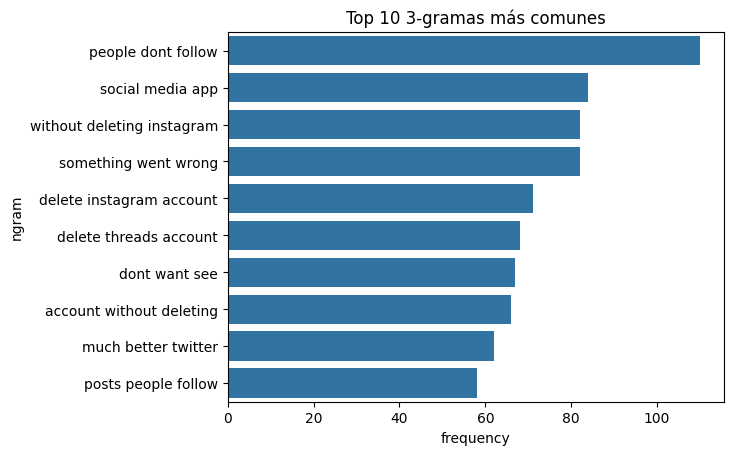

In [10]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(data['review_description'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 3-gramas más comunes')
plt.show()

Con 3-gramas tenemos incluso más información que antes, aunque siguen habiendo frases que podrian utilizarse en casi cualquier contexto.

Podemos ver que hay algunos del estilo "something wetn wrong", que probablemente son comentarios negativos hablando del mal funcionamiento de la app, y, puede que sea un comentario más complejo de lo normal al contener más que solo una crítica general.

También podemos notar que hay muchas frases con delete como "wihtout deleting instagram", "delete instagram account" o "delete threads account". Leyendo estas frases no se puede concluir a que estan haciendo referencia, pero probablemente están describiendo algún problema que tuvieron con el uso de la aplicación, por lo que probablemente son comentarios negativos, y, si hay muchas personas con el mismo problema, tiene sentido que estén entre las frases más frecuentes al ser un problema que afecta a muchos usuarios.

Como se pudo ver en los otros casos, persiste la rivalidad entre aplicaciones con comentarios como "much better twitter". De hecho, esta frase complementa todo lo que se ha dicho anteriormente y el como muchos usuarios prefieren twitter por sobre instagram.

El 3-grama más común es "people dont follow". Podríamos decir que el comentario es negativo ya que pareciera ser una queja con respecto a la aplicación o a los usuarios de la misma, aunque la frase sigue sin tener el contexto necesario para poder hacer una conclusión con respecto a por qué aparece entre las frases más comunes entre las reseñas.

Para el caso de los 3-gramas podemos notar que la mayoría de las frases parecieran estar relacionadas con aspectos negativos de la aplicación, contrario a lo que vimos en el caso de palabras y 2-gramas más frecuentes. Lo anterior parece tener relación con una observacion anterior en la que se dijo que los comentarios positivos probablemente destacan aquello que les gusta, mientras que los comentarios más neutrales o negativos describen su problema o hablan de forma más especifica con respecto a alguna característica de la aplicación.


## 3. Preguntas y Problemas
Luego del análisis a los datos con los que se trabajará en este proyecto, surgen las siguientes preguntas, las cuales se espera resolver usando tecnicas de mineria de datos.

1. ¿Es posible predecir si una reseña es positiva o negativa dado ciertos N-gramas?
2. ¿En cuántos clusters conviene separar las reviews? ¿Qué clusters se forman?
3. ¿Que dicen los LLM de nuestros datos?

# Hito 2

## Propuesta experimental

Como propuesta experimental, en este proyecto se hará uso de los métodos de clasificación para la 1 y 3 y clustering para la pregunta 2. Dado que clasificación es un método supervisado, adicionalmente se realizarán pruebas para obtener métricas de desempeño para escoger el mejor método de clasificación, mientras que, para el caso de clustering, al ser no supervisado, se deberán usar métodos para validar los clusters generados.

### Pregunta 1

Para responder la primera pregunta, se ha realizado un preprocesamiento que consta de, en primer lugar, la conversión del rating a palabras, a modo de limitar las categorías de originalmente 5 a 3. En segundo lugar, se hace la limpieza del dataset de aquellas palabras poco útiles para nuestro propósito, por lo que se filtran números, stopwords y se actualiza todo el texto del dataset de reseñas a minúsculas. Dado que, aún con la conversión de ratings existen categorías que quedan subrepresentadas en comparación a otras, se hace un oversampling basado en el rating de las reseñas para obtener un balanceo de datos para que los modelos generados sean mas correctos.

In [ ]:
# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating <= 4:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# funcion para realizar la limpieza del texto en el dataset
def clean(review):
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    return review

# funcion para hacer oversampling de los datos que se encuentran desbalanceados
def oversampling(X,y):
    ros = RandomOverSampler(random_state=42)
    X_resample, y_resample = ros.fit_resample(X, y)
    return (X_resample, y_resample)

Prosiguiendo con los N-gramas, se verá lo que ocurre con los 1-gramas. Primero, se procede con la vectorización, ya que se quiere convertir el texto a una forma que los algoritmos de aprendizaje que se usarán posteriormente puedan entender y procesar. En este caso, dado que en el preprocesamiento se estableció la necesidad de hacer oversampling a los datos, la vectorización será útil para luego poder hacer dicho oversampling. Finalmente, se realiza la división de los datos entre datos de prueba (con el 33% de los datos destinado para eso) y datos de entrenamiento. Adicionalmente, se usarán funciones extras otorgadas por la librería “joblib”, la cual será de utilidad para guardar los datos procesados, para no tener necesidad de ejecutar todo desde el principio, y asi conservar el entrenamiento. Esto es de especial importancia por lo que se mencionara a continuación.

Luego de almacenar la data útil para los algoritmos, se procede con el entrenamiento de los modelos. Para estos, se usarán principalmente los de clasificación, en particular Árboles de decisión, Naive Bayes, regresión logística y Support Vector Classifier. La elección de los modelos de clasificación esta guiada por el saber que tan viable es obtener una reseña positiva dados ciertos N-gramas. Ya que el entrenamiento es la parte mas pesada de este proceso, también se ha decidido el guardar la data mediante los comandos de joblib.

Cabe mencionar que en principio se realizarón comparaciones con respecto a los resultados obtenidos entre limitaciones a la vectorización eliminando todo aquel dato que tuviese baja representatividad y el dataset sin alteraciones. Los resultados para 1-gramas arrojaron las métricas que se muestran a continuación:

    Datos obtenidos en el dataset sin restricciones    |      Datos obtenidos en el dataset con min_df=0.0005
         Accuracy en test set: 0.753245910153207       |         Accuracy en test set: 0.7290963386133472
                                                       |
              precision    recall  f1-score   support  |                precision    recall  f1-score   support
                                                       |
    NEGATIVE       0.83      0.76      0.79      5135  |      NEGATIVE       0.81      0.73      0.77      5135
     NEUTRAL       0.76      0.74      0.75      5135  |       NEUTRAL       0.74      0.69      0.72      5135
    POSITIVE       0.69      0.76      0.73      5134  |      POSITIVE       0.65      0.76      0.70      5134
                                                       |
    accuracy                           0.75     15404  |      accuracy                           0.73     15404
    macro avg      0.76      0.75      0.75     15404  |     macro avg       0.74      0.73      0.73     15404
    weighted avg   0.76      0.75      0.75     15404  |  weighted avg       0.74      0.73      0.73     15404

Como es posible observar, las métricas obtenidas al limitar la vectorización del dataset son levemente inferiores a las métricas obtenidas con el dataset sin restricciones. Por esta razón, en favor de buscar el resultado más adecuado, y dado un posible aumento en las diferencias de metricas a medida que se procede con los siguiente N-gramas, se ha decidido usar los datasets sin alteraciones, pese a los tiempos de ejecución más lentos.

Se procede a cargar los modelos con "joblib" y a extraer las principales métricas de desempeño para medir cual de los modelos ha sido el mas confiable con el entrenamiento dado. Estas métricas ayudarán en la comparación de modelos para decidir cual de ellos es mejor para poder responder la pregunta planteada. Tanto para 2-gramas como 3-gramas, se sigue el mismo procedimiento descrito anteriormente. Cabe resaltar la importancia de la librería joblib, ya que el procesamiento del entrenamiento de los modelos es una tarea conocida por ser pesada computacionalmente hablando. Queda en el anexo todo el código descrito en esta explicación, mientras que en la sección de Experimento preliminar se presentan los principales resultados.

### Pregunta 2

Para la segunda pregunta, se siguen los mismos pasos del preprocesamiento en la pregunta anterior, añadiéndose la adición y edición de nuevas columnas que ayudarán en el trabajo de visualización de los datos. Se harán cambios de formato, eliminación de datos que no sean de interés para esta sección, se normalizarán datos y, principalmente, se cambiará el formato de muestra del rating, ya que para clustering se necesitara que este dato se exprese como valor entero.

In [ ]:
# Eliminaremos review_lists ya que solo eran para visualizar los datos
data = data.drop(['review_lists'], axis=1)
# Pasaremos las fechas a formato datetime
# Dias
data['review_date'] = pd.to_datetime(data['review_date']).apply(lambda x: (x.value)//(1_000_000_000*60*60*24))
# normalizar 0 a 1  las fechas
data['review_date'] = (data['review_date'] - data['review_date'].min()) / (data['review_date'].max() - data['review_date'].min())
# normalizar 0 a 1 length, wordcount, mean_word_length, mean_sent_length
data['Length'] = (data['Length'] - data['Length'].min()) / (data['Length'].max() - data['Length'].min())
data['Word_count'] = (data['Word_count'] - data['Word_count'].min()) / (data['Word_count'].max() - data['Word_count'].min())
data['mean_word_length'] = (data['mean_word_length'] - data['mean_word_length'].min()) / (data['mean_word_length'].max() - data['mean_word_length'].min())
data['mean_sent_length'] = (data['mean_sent_length'] - data['mean_sent_length'].min()) / (data['mean_sent_length'].max() - data['mean_sent_length'].min()) #
# Pasaremos algunas columnas a categoricas source, rating a int
data['source'] = data['source'].apply(lambda x: 1 if x == "Google Play" else 0)
# Ya que no necesitamos que sea visual los pasamos a entero
def ratingTransform(rating):
    if rating == "POSITIVE":
        return 2
    elif rating == "NEUTRAL":
        return 1
    else:
        return 0
data['rating'] = data['rating'].apply(ratingTransform)
# verifiquemos los tipos de columna
data.dtypes

Se definirán los valores X e Y que servirán para la formación de los grupos con los cuales los algoritmos de clustering trabajarán, y, usando X, se procede con Analisis de Componentes Principales, a modo de reducir tanto la dimensionalidad, como la complejidad de los datos, esto para que sea más fácil hallar patrones visibles en los clusters.

Los métodos de clustering a utilizar son, en principio, K-Means en un rango de 1 a 15 clusters, DBSCAN y algun algoritmo de clustering aglomerativo. Esto determinará cual sería la cantidad de clusters ideal para poder responder la pregunta. Para K-Means y DBSCAN, se utilizaran los métodos del codo y la rodilla, respectivamente. 

Para la validación, se contara con el uso de la metrica de Silhouette Score, la cual indicará que tan apropiado es el clustering, mediante la medición cuantitativa de que tan definidos esten los clusters. 

### Pregunta 3

Para responder la tercera pregunta, se hará fine-tuning de DistilBert, el cual es un proceso de entrenamiento en el que se usa un modelo pre-entrenado y se ajusta para que se adapte a los datos específicos del problema. En este caso, usaremos el modelo pre-entrenado de DistilBERT y lo ajustaremos para que se adapte a nuestros datos de entrenamiento.

Para esto importaremos los datos y le aplicaremos una función de rating. Posteriormente Usaremos tokenizers para convertir una secuencia de texto en una secuencia de tokens (números que hacen referencia a palabras).

In [ ]:
# leemos el csv
df = pd.read_csv("threads.csv")
df = df.drop(["source", "review_date"], axis=1)
# change the column names to match the HuggingFace dataset format
df = df.rename(columns={"review": "text", "rating": "label"})

# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return 0
    elif rating <= 4:
        return 1
    else:
        return 2

# Transform the ratings to positive, neutral, and negative
df["label"] = df["label"].apply(ratingTransform)

train, test = train_test_split(df, test_size=0.33)

# guardamos los datos en un csv
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

# cargamos los datos en un dataset de huggingface
dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})

# Entrenemos un modelo DistilBERT
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#max_length = 512
# Tokenizamos los datos
def tokenize_data(example):
    return tokenizer(example['review_description'], padding='max_length', truncation=True)

# tokenizamos los datos
dataset = dataset.map(tokenize_data, batched=True)

Cargaremos el modelo DistilBERT, que es un modelo de BERT más pequeño y rápido, pero que mantiene una precisión similar a la de BERT. Posteriormente haremos fine-tuning a DistilBERT, para finalmente evaluarlo en el conjunto de datos de prueba, para ver cómo se desempeña en datos que nunca ha visto antes y realizar un experimento para ver sobre ciertas reviews cuales son las palabras que más influyen en el modelo. 

# Hito 3

## Experimentos

### Pregunta 1

Aqui se añaden los principales resultados obtenidos de la experimentación en esta pregunta. Se mostrarán las tablas con las métricas de desempeño obtenidas por cada N-grama del 1 al 3. Para simplificación de la muestra, P = precision, R = recall, F1 = F1-score y S = support. A su vez, los modelos se nombran como DTC = DecisionTreeClassifier, NB = Naive Bayes, LR = Regresión logistica y SVC = Support Vector Machine. Como se ha mencionado anteriormente, para obtener estos resultados se usó el dataset sin restricciones, esto a modo de obtener los mejores resultados posibles en cuanto a métricas.

                         1-grama                    2-grama                    3-grama
          
    Accuracy test set: 0.753245910153207  |      0.7294209296286679  |       0.642235782913529
  
         > DTC <  P     R     F1    S     |  P     R     F1    S     |  P     R     F1    S     

        NEGATIVE  0.83  0.76  0.79  5135  |  0.89  0.61  0.72  5135  |  0.93  0.36  0.52  5135
         NEUTRAL  0.76  0.74  0.75  5135  |  0.84  0.70  0.76  5135  |  0.93  0.60  0.73  5135
        POSITIVE  0.69  0.76  0.73  5134  |  0.59  0.88  0.71  5134  |  0.49  0.97  0.65  5134

        accuracy              0.75 15404  |              0.73 15404  |              0.64 15404
       macro avg  0.76  0.75  0.75 15404  |  0.77  0.73  0.73 15404  |  0.79  0.64  0.63 15404
    weighted avg  0.76  0.75  0.75 15404  |  0.77  0.73  0.73 15404  |  0.79  0.64  0.63 15404
    
    --------------------------------------+--------------------------+----------------------------
    
    Accuracy test set: 0.6999480654375487 |      0.7174759802648663  |      0.6345754349519606
    
          > NB <  P     R     F1    S     |  P     R     F1    S     |  P     R     F1    S   

        NEGATIVE  0.80  0.71  0.75  5135  |  0.88  0.61  0.72  5135  |  0.94  0.34  0.50  5135
         NEUTRAL  0.68  0.56  0.62  5135  |  0.80  0.66  0.72  5135  |  0.94  0.58  0.72  5135
        POSITIVE  0.64  0.83  0.72  5134  |  0.59  0.88  0.71  5134  |  0.49  0.98  0.65  5134

        accuracy              0.70 15404  |              0.72 15404  |              0.63 15404
       macro avg  0.71  0.70  0.70 15404  |  0.76  0.72  0.72 15404  |  0.79  0.63  0.62 15404
    weighted avg  0.71  0.70  0.70 15404  |  0.76  0.72  0.72 15404  |  0.79  0.63  0.62 15404
    
    --------------------------------------+--------------------------+----------------------------
    
    Accuracy test set: 0.7331212672033238 |       0.738314723448455  |      0.6490521942352636
            
          > LR <  P     R     F1    S     |  P     R     F1    S     |  P     R     F1    S   

        NEGATIVE  0.82  0.75  0.78  5135  |  0.90  0.63  0.74  5135  |  0.92  0.38  0.54  5135
         NEUTRAL  0.75  0.61  0.67  5135  |  0.84  0.68  0.75  5135  |  0.94  0.60  0.73  5135
        POSITIVE  0.66  0.84  0.74  5134  |  0.61  0.91  0.73  5134  |  0.50  0.97  0.66  5134

        accuracy              0.73 15404  |              0.74 15404  |              0.65 15404
       macro avg  0.74  0.73  0.73 15404  |  0.78  0.74  0.74 15404  |  0.79  0.65  0.64 15404
    weighted avg  0.74  0.73  0.73 15404  |  0.78  0.74  0.74 15404  |  0.79  0.65  0.64 15404
    
    --------------------------------------+--------------------------+----------------------------
     
    Accuracy test set: 0.729940275253181  |      0.6929368995066216  |  
         > SVC <  P     R     F1    S     |  P     R     F1    S     |  P     R     F1    S   

        NEGATIVE  0.82  0.75  0.78  5135  |  0.77  0.65  0.71  5135  |  -     -     -     -
         NEUTRAL  0.82  0.58  0.68  5135  |  0.90  0.58  0.70  5135  |  -     -     -     -
        POSITIVE  0.63  0.86  0.73  5134  |  0.56  0.85  0.68  5134  |  -     -     -     -

        accuracy              0.73 15404  |              0.69 15404  |  -     -     -     -
       macro avg  0.75  0.73  0.73 15404  |  0.75  0.69  0.70 15404  |  -     -     -     -
    weighted avg  0.75  0.73  0.73 15404  |  0.75  0.69  0.70 15404  |  -     -     -     -

Como es posible apreciar, basandonos principalmente en el Accuracy obtenido para cada modelo, tanto 1-gramas como 2-gramas presentan mejores resultados en comparación a los obtenidos en los 3-gramas. Esto puede explicarse debido a la existencia de palabras las cuales se repiten mucho, lo que a su vez alteraría las métricas a medida que se avanza por los N-gramas. Por lo regular, las reseñas Negativas son las que poseen la precisión más alta, pero las reseñas positivas presentan un mejor Recall. A su vez, debido a limitaciones de tiempo y de recursos computacionales, se omitirán los resultados para Support Vector Machine de 3-grama, pero basándose en resultados previos obtenidos, probablemente el modelo no sea significativamente mejor que los demás, mucho menos por el tiempo que tarda su ejecución. Es posible obtener buenos resultados en un tiempo comparablemente mejor con otros modelos.

A continuación, se muestran los Árboles de decisión generados a partir de los modelos entrenados

#### Decision Tree para 1-grama

![dt1.png](dt1.png)

En base a el árbol de 1-grama no es posible inferir mucho a que se debe que la presencia de ciertas palabras hacen que una review sea positiva o negativa

#### Decision Tree para 2-grama

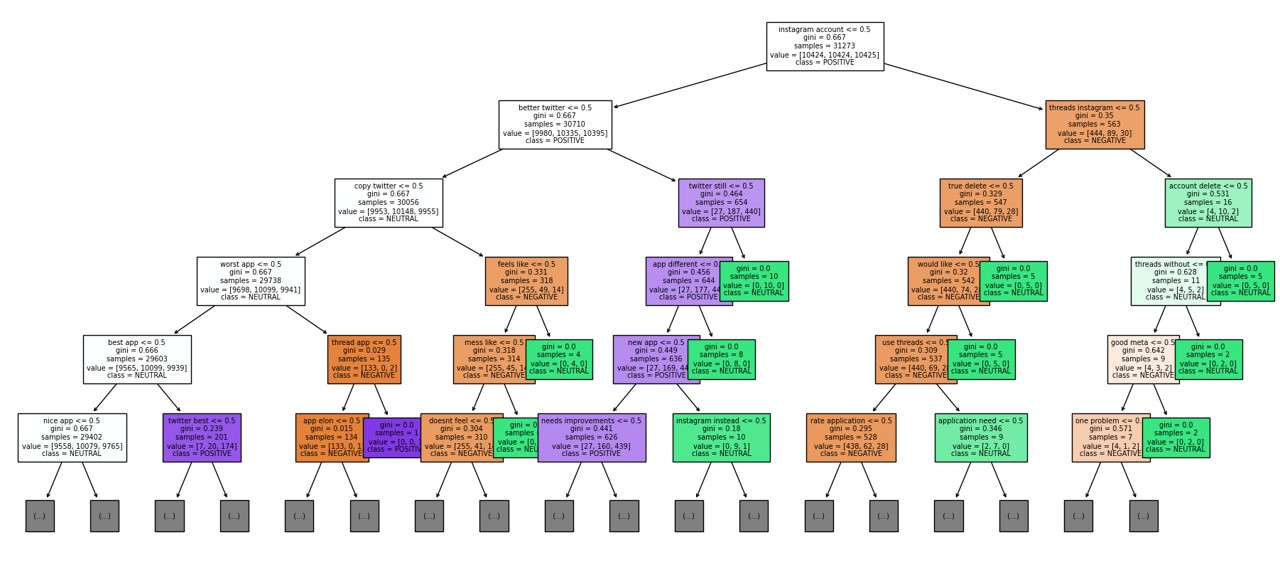

En base a el árbol de 2-grama es posible ver como el tema de que la cuenta de threads sea ligada a Instagram da como resultado reviews negativas o el mejor de los casos neutra, por otra parte las comparaciones con twitter algunas dan resultados negativos (si lo creen copia) y otras positivas como (better twitter)

#### Decision Tree para 3-grama

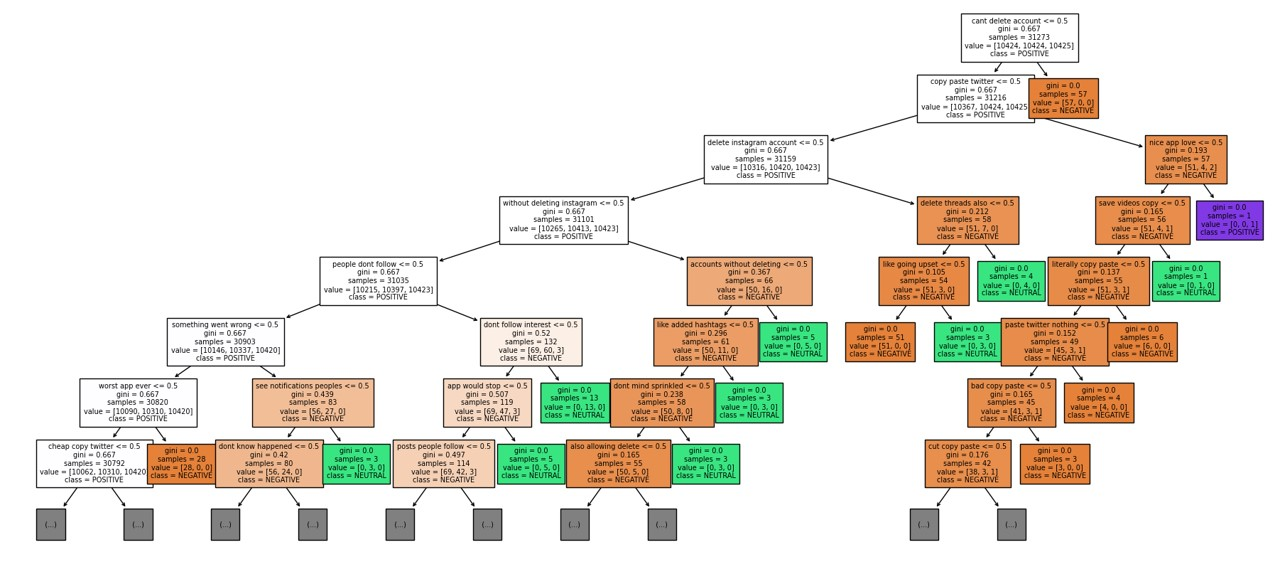

En base a el árbol de 3-grama es posible observar como el tema de no poder borrar la cuenta esta relacionada con reviews negativas, a su vez es posible observar como en general esta haciendo en cada nivel divisiones muy ajustadas en las cuales se va obteniendo un resultado para pocos casos.

Con esto, adicionalmente se puede mostrar un caso de prueba como sigue, en el cual se arroja una reseña cualquiera para comprobar su categorización realizada por uno de los modelos (ha sido escogido Decision Tree, ya que es el de mejor accuracy). El código será proporcionado en el anexo.

    review = "This app is pretty good, but it could be better"  ->   ['NEUTRAL']

    review2 = "This app is kinda bad, but it has some good features though"  ->   ['NEGATIVE']

    review3 = "This app is fantastic, I love it"  ->   ['POSITIVE']

    review4 = "This app is terrible, I hate it"  ->   ['NEGATIVE']

Así, es posible concluir que la pregunta planteada puede ser respondida: ¿Es posible predecir si una reseña es positiva o negativa dado ciertos N-gramas?
La respuesta es sí, como se ha demostrado arriba, otorgar un N-grama a un modelo, y elegir aquel que tenga unas buenas métricas de desempeño, puede arrojar resultados bastante buenos a la hora de dar nuevas reviews. Eso si, hay que tener cuidado en estas situaciones, dado que determinados comentarios pueden presentar un sesgo debido al uso del modelo, principalmente porque se maneja material subjetivo, por lo que qué una reseña este posicionada como POSITIVA no significa directamente que la reseña esté planteada de esa forma. Básicamente, depende de la percepción de la persona quien escribe.

### Pregunta 2

Se replanteó el proceso de clustering, eliminando la restricción min_df y ampliando la visuallizacion con PCA a 3 dimensiones

Adicionalmente,se concretó usar K-means para el clustering, dado que en el hito anterior fue el de mayor Silhouette Score. Sin embargo, como se quitará la restricción de min_df, se analizará nuevamente el "codo" (usando el mismo codigo)



In [ ]:
# Definimos la función para plottear en 3D

from mpl_toolkits.mplot3d import Axes3D
def plot3D(pca, angles = (90,-90), label=None):
    elev, azim = angles
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2], c=label)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.view_init(elev=elev, azim=azim)
    ax.view_init(elev=elev, azim=azim)
    plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3) ## Con 3 dimensiones
pca.fit(X)
joblib.dump(pca, 'modelos/pca2.joblib')

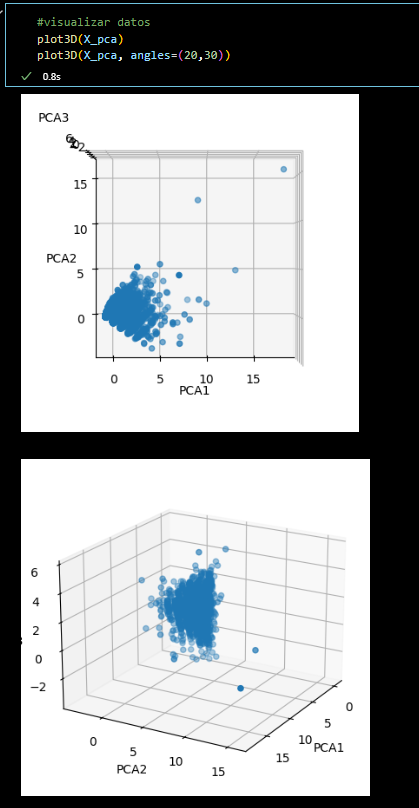

Notese que el clustering es similar al del hito 2. Sin embargo, se observa que estan mas contiguos los clusters y se puede observar que los puntos son bastantes cercanos

Visualmente se pueden observar 5 figuras elongadas y paralelas entre ellas, se sospecha que estos podrían corresponder a los clusters

### KMeans

Usamos el método del codo para 1-15 clusters, con lo que se obtuvo el siuente grafico:

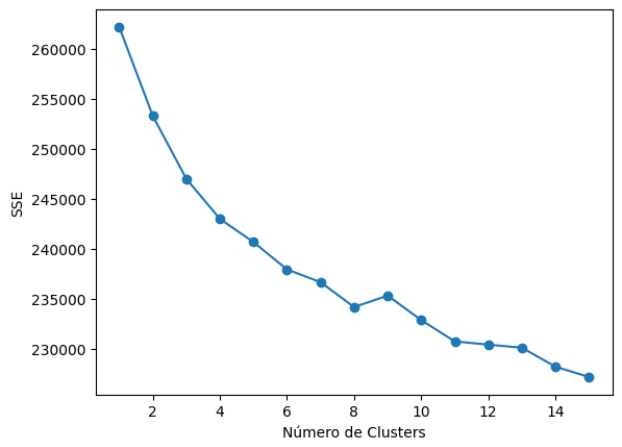


Se determina que 3 clusters es la cantidad optima de clusters (notese que es cercano a la mayor cantidad de clusters obtenido en el hito anterior) según el método del codo

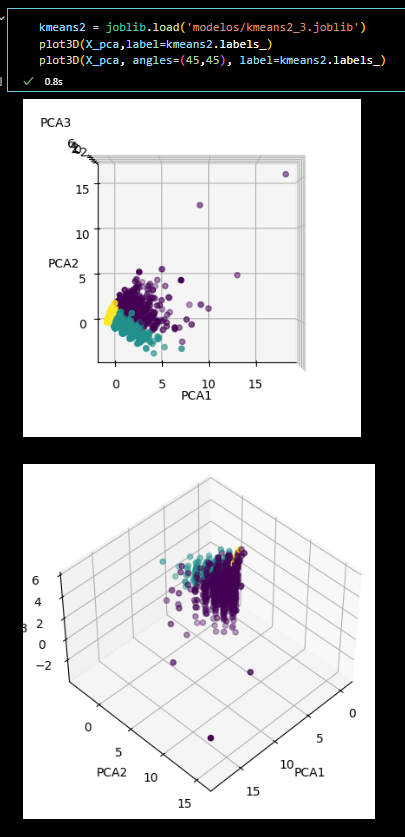


## Análisis de clusters

Ya que se decidio el modelo de clustering, en este hito nos enfocaremos en ver en como las reseñas fueron agrupadas. Utilizaremos una función para tomar muestras de cada cluster y un dataframe *raw_data* que es una copia de los datos antes del procesamiento

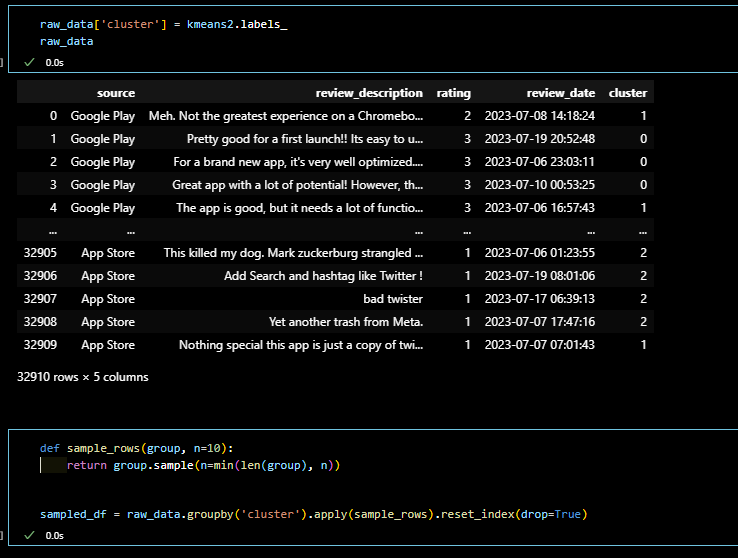

#### Cluster-0

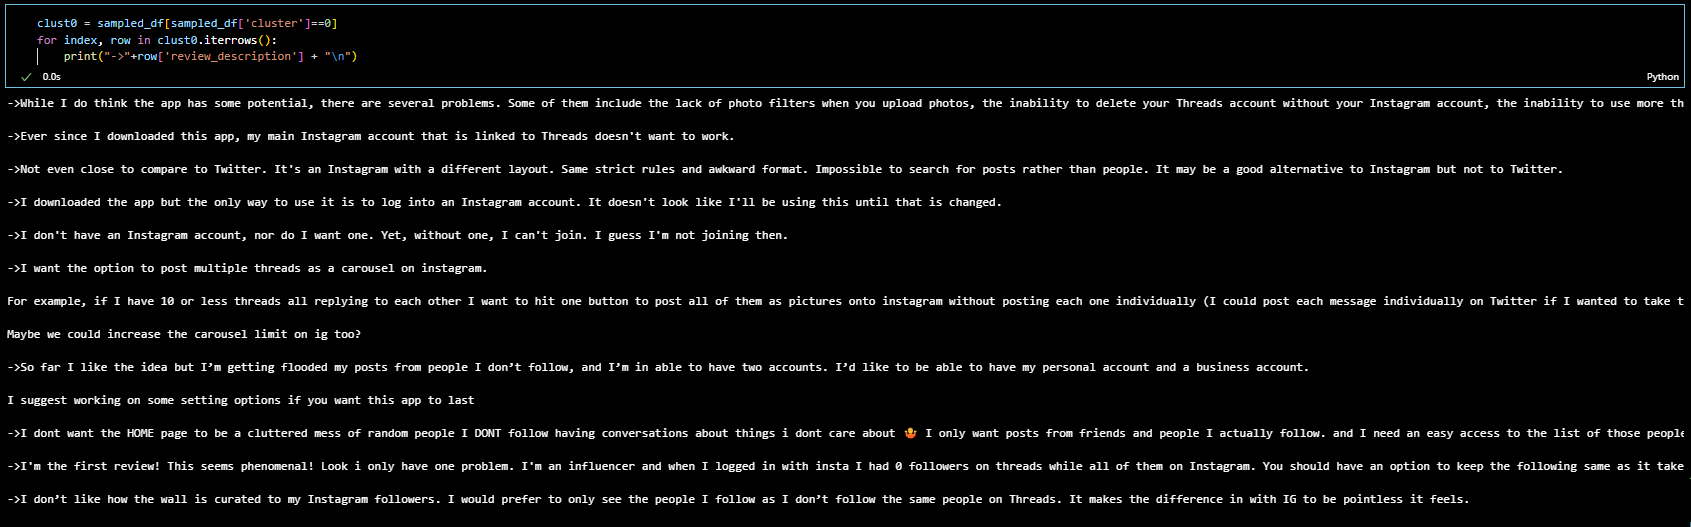

Notamos que en este cluster las reseñas suelen ser bastante largas, por lo que este atributo es el identificador de este cluster ("Reseñas largas")

#### Cluster-1

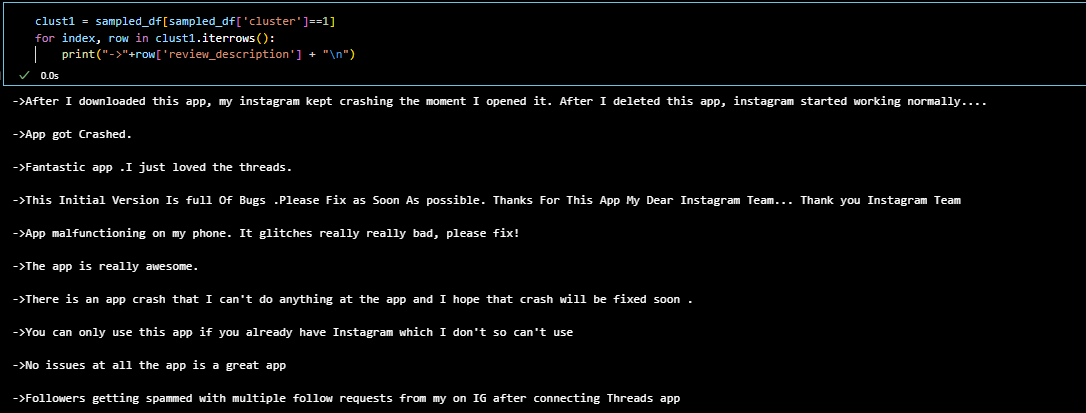

Por otra parte, las reseñas en este cluster son de un largo menor, pero siguen siendo -en su mayoria- comentarios elaborados. Podemos identificar este cluster como "Reseñas medianas"

#### Cluster-2

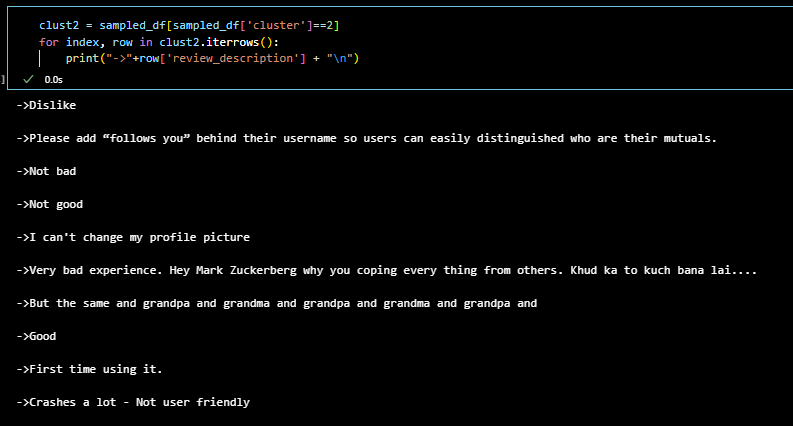

Finalmente, en este cluster se observan reseñas mucho más cortas, incluso algunas de 1-2 palabras  (lo cual no fue observado en ningun otro cluster). Podemos identificar este cluster como "Reseñas cortas".

Respondiendo a la pregunta. Los clusters que se forman pareciesen estar segregados según los largos de la reseña (No se ve en los pantallazos, pero en los demás atributos como source, rating, etc. no se observó ningun patrón ni grupo particular).
Esto puede deberse a los datos de input, pues no solo contenian texto vectorizado sino que también contenia como atributos los largos de las palabras. Lo cual pudo haber impactado significativamente en como se hacen los clusters.

Es importante notar que los grupos no son totalmente segregados, pues hay algo se solapamiento entre los clusters de reseñas medianas y cortas, lo cual es indicativo de que el clustering requiere mayor tuning.

Finalmente, recalcar que el hecho de que los clusters separen por largo puede ser altamente impactado por los datos alimentados, en particular la inclusión misma de los largos como input para el clustering. De forma que se deben considerar estos factores en la respuesta a la pregunta

### Pregunta 3

Para este experimento primero transformamos los datos del dataset para separarlos en clases distintas y asi tener clases menos desbalanceadas.
Luego, se utilizo el tokenizador de 'distilbert-case-uncased' para que el modelo pueda trabajar con los datos del dataset.

Para este experimento utilizamos la tecnologia de nvidia CUDA para poder hacer fine-tuning. Al utilizar CUDA se pudo pasar de un tiempo esperado de ~30 horas a un tiempo esperado de ~2 horas, esto permitio realizar los experimentos de mejor forma.

A la hora de entrenar el modelo, se le entrego una función al trainer para poder calificar que tan bien clasificaba el modelo. La función contiene metricaz como precision, accuracy, recall y f1 score. Esto ayudo en que el trainer nos entregaba todos los resultados luego de ser entrenado.

Resultados del trainer:

Se mostrará una tabla con las métricas de desempeño obtenidas por el modelo DistilBERT entrenado con nuestro dataset. 

                  Metricas del modelo
      eval_loss               0.6384
      eval_accuracy           0.7639
      eval_f1                 0.7514
      eval_precision          0.7494
      eval_recall             0.7639
      eval_runtime            102.3634,
      eval_samples_per_second 106.102,
      eval_steps_per_second   13.266,
      epoch                   7.0       

En base a los resultados, podemos decir que el modelo no logra aprender completamente la tarea que se le asigno, ya que la presición obtenida por el modelo no es tan alta. Por otro lado, el modelo logra resultados bastante consistentes en otras métricas, por lo que pensamos que el modelo logra aprender parte de la tarea que le asignamos pero le faltaron datos para entender completamente como clasificarlos. También puede ser que hay comentarios muy dificiles de clasificar, por lo que el modelo no puede aprender a clasificarlos.

#### Interpretación del modelo

Luego, utilizando la libreria de transformers_interpret, se probo algunos ejemplos nuevos para ver si el modelo se adaptó aprendio del dataset y si es capaz de generalizar a nuevos comentarios. La librería también nos permite ver cuales son las palabras que más le importan al modelo a la hora de hacer su clasificación.

Le entregamos algunos casos en los que la clasificación debería ser clara y así poder hacer una comprobación rápida. Además, nos fijamos en las palabras con mayor importancia para la clasificación para ver si en efecto el modelo entiende que palabras importan.

a)    "best app! I really like it. better than twitter":    
Esta review es bastante simple y debería ser clasificada como positiva. Como se puede ver a continuación el modelo la predice como positiva y la palabra mas importante para esta predicción es "best". Por lo que en este caso la clasificación es bastante buena.

![pregunta3a](img_generadas\ppregunta3a.png)

b)    "its neither good nor bad.":
Esta review deberia ser neutral. Como se puede ver a continuación el modelo la predice como neutral y se fija en varias palabras para poder hacer su clasificación. El modelo asigna una importancia significativamente mayor a la palabra 'neither' en comparación con 'bad' o 'good'. Esto indica que el modelo reconoce que la clasificación no se limita únicamente a términos como 'good' o 'bad', sino que también valora y da prioridad a términos como 'neither'.

![pregunta3b](img_generadas\ppregunta3b.png)

c)    "I recently installed this app due to its popularity, but my initial impression is quite negative. I haven't found anything that I like about it.":
Esta review deberia ser negativa y el modelo logra predecirla como negativa. Este comentario es bastante largo y contiene varias palabras pero el modelo logra reconocer que hay mayor cantidad de palabras negativas en el comentario y clasifica correctamente.

![pregunta3c](img_generadas\ppregunta3c.png)

El modelo logra unos resultados bastante buenos en general, entiende bien que palabras son importantes para poder clasificar y logra clasificar gran parte de los datos. Aún así, el modelo no logra unos resultados perfectos y esto puede tener relación con los datos utilizados, puede ser que los datos que le entregamos al modelo no sean los mejores o quiza le faltan más datos para el entrenamiento. 

Finalmente, se consigio que un LLM entendiera parte del problema de clasificación, probablemente por la gran capacidad de estos modelos, pero no se pudo conseguir un rendimiento tan bueno como el esperado.

# Conclusiones finales

De los resultados obtenidos, se puede respaldar que, en principio, es posible responder la primera pregunta planteada. El proceso de entrenamiento de un algoritmo de clasificación, pese a ser extremadamente lento en ciertos casos, arroja resultados favorables a la hora de probar nuevas reseñas, clasificandolas apropiadamente dentro de los parametros esperados. Pese a ello, de haber tenido más tiempo disponible para el proyecto, habría sido ideal encontrar maneras las cuales aseguraran buenas metricas en tiempos más cortos, o bien, realizar modificaciones pertinentes a la base de datos (sea el caso presente, donde se usó oversampling para aumentar la cantidad de datos para cierto parametro), esto a modo de aumentar los valores obtenidos en las métricas y, en consecuencia, mejorar el nivel de predicción del algoritmo. De todas formas, para la pregunta 1, los resultados son satisfactorios. 

Ahora bien, con respecto a la pregunta 2...

Finalmente, sobre la pregunta 3...

# Anexo

Todo el codigo provisto a continuación fue ejecutado en archivos distintos a este, la asignación de cada problema queda definida al final de este documento. 

## Codigo Pregunta 1
### 1-gram
Para correr el programa de esta pregunta, se recomienda acceder a los archivos alojados en el siguiente drive: https://1drv.ms/f/s!AlZ34M3EGUu_hIBfv6Sj8bHwzV2uFA?e=l8PYTY, esto a modo de evitar largas jornadas de ejecución. Los archivos deben de encontrarse en una subcarpeta de nombre "modelos", dentro de la misma carpeta que este documento. 

In [ ]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data["review_description"])
vectorized = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
joblib.dump(vectorizer.get_feature_names_out(), "modelos/1-gram_vectorizer.pkl")
X_1gram = vectorized
X_1gram, y1 = oversampling(X_1gram, Y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1gram, y1, test_size=0.33, random_state=37,stratify=y1)
joblib.dump(X1_train, 'modelos/X1_train.pkl')
joblib.dump(X1_test, 'modelos/X1_test.pkl')
joblib.dump(y1_train, 'modelos/y1_train.pkl')
joblib.dump(y1_test, 'modelos/y1_test.pkl')

**Dataset con mindf = 0.0005**

In [ ]:
vectorizer = CountVectorizer(min_df=0.0005)
vectors = vectorizer.fit_transform(data["review_description"])
vectorized = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
X_11gram = vectorized
X_11gram, y11 = oversampling(X_11gram, Y)
X11_train, X11_test, y11_train, y11_test = train_test_split(X_11gram, y11, test_size=0.33, random_state=37,stratify=y11)
joblib.dump(X11_train, 'modelos/X11_train.pkl')
joblib.dump(X11_test, 'modelos/X11_test.pkl')
joblib.dump(y11_train, 'modelos/y11_train.pkl')
joblib.dump(y11_test, 'modelos/y11_test.pkl')

### Entrenar Modelos
**Dataset sin limitaciones**

In [ ]:
X1_train = joblib.load('modelos/X1_train.pkl')
y1_train = joblib.load('modelos/y1_train.pkl')

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X1_train, y1_train) 
joblib.dump(clf, "modelos/1-gram_trained_DecisionTreeClassifier.joblib")

In [ ]:
clf = MultinomialNB()
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_trained_NV.joblib")

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_logistic_regesion.joblib")

In [ ]:
clf = SVC()
clf.fit(X1_train, y1_train)
joblib.dump(clf, "modelos/1-gram_trained_svc.joblib")

**Dataset con mindf = 0.0005**

In [ ]:
X11_train = joblib.load('modelos/X11_train.pkl')
y11_train = joblib.load('modelos/y11_train.pkl')

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X11_train, y11_train) 
joblib.dump(clf, "modelos/1-gram_trained_DecisionTreeClassifier_md.joblib")

In [ ]:
clf = MultinomialNB()
clf.fit(X11_train, y11_train)
joblib.dump(clf, "modelos/1-gram_trained_NV_md.joblib")

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X11_train, y11_train)
joblib.dump(clf, "modelos/1-gram_logistic_regesion_md.joblib")

In [ ]:
clf = SVC()
clf.fit(X11_train, y11_train)
joblib.dump(clf, "modelos/1-gram_trained_svc_md.joblib")

### Cargar modelos para evaluar
**Dataset sin limitaciones**

In [ ]:
X1_test = joblib.load('modelos/X1_test.pkl')
y1_test = joblib.load('modelos/y1_test.pkl')

In [ ]:
clf = joblib.load("modelos/1-gram_trained_DecisionTreeClassifier.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

In [ ]:
# Prueba de predicción con un review de ejemplo
review = "This app is pretty good, but it could be better"
print(clf.predict(vectorizer.transform([review])))
review2 = "This app is kinda bad, but it has some good features though"
print(clf.predict(vectorizer.transform([review2])))
review3 = "This app is fantastic, I love it"
print(clf.predict(vectorizer.transform([review3])))
review4 = "This app is terrible, I hate it"
print(clf.predict(vectorizer.transform([review4])))

In [ ]:
vectorizer = joblib.load("modelos/1-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 4, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [ ]:
clf = joblib.load("modelos/1-gram_trained_NV.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

In [ ]:
clf = joblib.load("modelos/1-gram_logistic_regesion.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

In [ ]:
clf = joblib.load("modelos/1-gram_trained_svc.joblib")
y1_pred = clf.predict(X1_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y1_test, y1_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y1_test, y1_pred))

**Dataset con mindf = 0.0005**

In [ ]:
X11_test = joblib.load('modelos/X11_test.pkl')
y11_test = joblib.load('modelos/y11_test.pkl')

In [ ]:
clf = joblib.load("modelos/1-gram_trained_DecisionTreeClassifier_md.joblib")
y11_pred = clf.predict(X11_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y11_test, y11_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y11_test, y11_pred))

In [ ]:
clf = joblib.load("modelos/1-gram_trained_NV_md.joblib")
y11_pred = clf.predict(X11_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y11_test, y11_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y11_test, y11_pred))

In [ ]:
clf = joblib.load("modelos/1-gram_logistic_regesion_md.joblib")
y11_pred = clf.predict(X11_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y11_test, y11_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y11_test, y11_pred))

In [ ]:
clf = joblib.load("modelos/1-gram_trained_svc_md.joblib")
y11_pred = clf.predict(X11_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y11_test, y11_pred))   ## Evaluamos la predicción comparando y_test con y1_pred
print(classification_report(y11_test, y11_pred))

### 2-gram

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['review_description'])
bigrams = pd.DataFrame(bigrams.toarray(), columns=cv.get_feature_names_out())
joblib.dump(bigrams.get_feature_names_out(), "modelos/2-gram_vectorizer.pkl")
X_2gram = bigrams
X_2gram, y2 = oversampling(X_2gram, Y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2gram, y2, test_size=0.33, random_state=37,stratify=y2)
joblib.dump(X2_train, 'modelos/X2_train.pkl')
joblib.dump(X2_test, 'modelos/X2_test.pkl')
joblib.dump(y2_train, 'modelos/y2_train.pkl')
joblib.dump(y2_test, 'modelos/y2_test.pkl')

### Entrenar Modelos

In [ ]:
X2_train = joblib.load('modelos/X2_train.pkl')
y2_train = joblib.load('modelos/y2_train.pkl')

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X2_train, y2_train) 
joblib.dump(clf, "modelos/2-gram_trained_DecisionTreeClassifier.joblib")

In [ ]:
clf = MultinomialNB()
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_trained_NV.joblib")

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_logistic_regesion.joblib")

In [ ]:
clf = SVC()
clf.fit(X2_train, y2_train)
joblib.dump(clf, "modelos/2-gram_trained_svc.joblib")

### Evaluar Modelos

In [ ]:
X2_test = joblib.load('modelos/X2_test.pkl')
y2_test = joblib.load('modelos/y2_test.pkl')

In [ ]:
clf = joblib.load("modelos/2-gram_trained_DecisionTreeClassifier.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

In [ ]:
vectorizer = joblib.load("modelos/2-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 5, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [ ]:
clf = joblib.load("modelos/2-gram_trained_NV.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

In [ ]:
clf = joblib.load("modelos/2-gram_logistic_regesion.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

In [ ]:
clf = joblib.load("modelos/2-gram_trained_svc.joblib")
y2_pred = clf.predict(X2_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y2_test, y2_pred))   ## Evaluamos la predicción comparando y2_test con y2_pred
print(classification_report(y2_test, y2_pred))

###  3-gram

In [ ]:
cv1 = CountVectorizer(ngram_range=(3,3),min_df=0.00005)
trigrams = cv1.fit_transform(data['review_description'])
trigrams = pd.DataFrame(trigrams.toarray(), columns=cv1.get_feature_names_out())
X_3gram = trigrams
X_3gram, y3 = oversampling(X_3gram, Y)
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3gram, y3, test_size=0.33, random_state=37,stratify=y3)
joblib.dump(X3_train, 'modelos/X3_train.pkl')
joblib.dump(X3_test, 'modelos/X3_test.pkl')
joblib.dump(y3_train, 'modelos/y3_train.pkl')
joblib.dump(y3_test, 'modelos/y3_test.pkl')

### Entrenar Modelos

In [ ]:
X3_train = joblib.load('modelos/X3_train.pkl')
y3_train = joblib.load('modelos/y3_train.pkl')

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X3_train, y3_train) 
joblib.dump(clf, "modelos/3-gram_trained_DecisionTreeClassifier.joblib")

In [ ]:
clf = MultinomialNB()
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_trained_NV.joblib")

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_logistic_regesion.joblib")

In [ ]:
clf = SVC()
clf.fit(X3_train, y3_train)
joblib.dump(clf, "modelos/3-gram_trained_svc.joblib")

### Evaluar modelos

In [ ]:
X3_test = joblib.load('modelos/X3_test.pkl')
y3_test = joblib.load('modelos/y3_test.pkl')

In [ ]:
clf = joblib.load("modelos/3-gram_trained_DecisionTreeClassifier.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

In [ ]:
vectorizer = joblib.load("modelos/3-gram_vectorizer.pkl")
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 7, feature_names=vectorizer,  class_names=clf.classes_, filled=True)
plt.show()

In [ ]:
clf = joblib.load("modelos/3-gram_trained_NV.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

In [ ]:
clf = joblib.load("modelos/3-gram_logistic_regesion.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

In [ ]:
clf = joblib.load("modelos/3-gram_trained_svc.joblib")
y3_pred = clf.predict(X3_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y3_test, y3_pred))   ## Evaluamos la predicción comparando y3_test con y3_pred
print(classification_report(y3_test, y3_pred))

## Codigo Pregunta 2

In [ ]:
# Mismo preprocesamiento que Pregunta 3

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data["review_description"])

vectorized = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

data = data.drop(['review_description'], axis=1)
data = pd.concat([data, vectorized], axis=1)

data

In [ ]:
# Definimos X e Y
X = data.drop(['rating'], axis=1)
Y = data['rating']

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

#visualizar datos
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA')
plt.show()

### KMeans

In [ ]:
# Codo

sse = []

clusters = list(range(1,16))
for i in clusters:
    kmeans = KMeans(n_clusters=i, n_init="auto", max_iter=100, random_state=42).fit(X) # fit retorna a self
    sse.append(kmeans.inertia_)
plt.plot(clusters, sse, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

# KMeans 2-Cluster
kmeans2 = KMeans(n_clusters=2, n_init = "auto", max_iter=500, random_state=42).fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans2.labels_)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA')
plt.show()

# KMeans 5-Cluster
kmeans5 = KMeans(n_clusters=5, n_init = "auto", max_iter=500, random_state=42).fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans5.labels_)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA')
plt.show()

# KMeans 8-Cluster
kmeans8 = KMeans(n_clusters=8, n_init = "auto", max_iter=500, random_state=42).fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans8.labels_)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA')
plt.show()

### Agglomerative Clustering (Single)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Con metrica coseno ocurre error "Zero vectors"

single = linkage(X_pca, method="single")


dendrogram(single)
plt.title("Linkage Single")
plt.show()

In [ ]:
# Cortamos dendograma en y=1
single_all = AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=1).fit(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=single_all.labels_)
plt.title("Clusters con Single")
plt.show()

### DBSCAN

In [ ]:
# Rodilla

from sklearn.neighbors import NearestNeighbors
import numpy as np
import kneed

# Heuristic k = sqrtN
k= 180
# KNN
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Localizar rodilla
rodilla = kneed.KneeLocator(range(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing")
plt.axhline(y=rodilla.knee_y, color='r', linestyle='--') 
plt.plot(distances)

In [ ]:
# Para DBSCAN metodo rodilla no sirve, pues es una metrica acotada y que funciona totalmente distinto a la distancia eucleidiana
# DBSCAN debil contra clusters cercanos con densidades similares

from sklearn.cluster import DBSCAN
k=180
dbscan = DBSCAN(eps=8.889618397402987, min_samples=k).fit(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan.labels_)
plt.title("Clusters con DBSCAN")
plt.show()

print("Número de clusters: ", len(set(dbscan.labels_))-1)

### Validación

In [ ]:
from sklearn.metrics import silhouette_score

print("Dataset X, Silhouette Score (K-Means, 2-clusters):\t", silhouette_score(X, kmeans2.labels_))
print("Dataset X, Silhouette Score (K-Means, 5-clusters):\t", silhouette_score(X, kmeans5.labels_))
print("Dataset X, Silhouette Score (K-Means, 8-clusters):\t", silhouette_score(X, kmeans8.labels_))
print("Dataset X, Silhouette Score (Single Linkeage):\t", silhouette_score(X, single_all.labels_))

## Codigo Pregunta 3
### Dataset threads

In [ ]:
data = pd.read_csv("threads.csv") # carga del dataset a usar como variable

In [ ]:
# Pasaremos las fechas a formato datetime
# Dias
data['review_date'] = pd.to_datetime(data['review_date']).apply(lambda x: (x.value)//(1_000_000_000*60*60*24))
# normalizar 0 a 1  las fechas
data['review_date'] = (data['review_date'] - data['review_date'].min()) / (data['review_date'].max() - data['review_date'].min())

# Pasaremos algunas columnas a categoricas source, rating a int
data['source'] = data['source'].apply(lambda x: 1 if x == "Google Play" else 0)

# verifiquemos los tipos de columna
data.head(10)

In [ ]:
fechas = []
calificaciones = [[],[],[],[],[]]

r_date = data["review_date"]
rating = data["rating"]

for i in range(len(r_date)):
    if r_date[i] not in fechas:
        fechas.append(r_date[i])
        calificaciones[(rating[i]-1)%5].append(1) ## posicion buscada
        for k in range(4): 
            calificaciones[(rating[i]+k)%5].append(0)
    else:
        index = fechas.index(r_date[i])
        calificaciones[(rating[i]-1)%5][index] += 1
        
colores = "rbymg"
for k in range(5):
    sorted_pairs = sorted(zip(fechas, calificaciones[k]))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, linestyle="-", color=colores[k], label=str(k+1))

    plt.xlabel('Fechas')
plt.ylabel('Cantidad de reviews')
plt.title('Agglomerative Clustering (Single)')
plt.legend()
plt.show()

### Dataset Instagram

In [ ]:
data = pd.read_csv("instagram.csv")

In [ ]:
# Pasaremos las fechas a formato datetime
# Dias
data['review_date'] = pd.to_datetime(data['review_date']).apply(lambda x: (x.value)//(1_000_000_000*60*60*24))
# normalizar 0 a 1  las fechas
data['review_date'] = (data['review_date'] - data['review_date'].min()) / (data['review_date'].max() - data['review_date'].min())

# verifiquemos los tipos de columna
data.head(10)

In [ ]:
fechas = []
calificaciones = [[],[],[],[],[]]

r_date = data["review_date"]
rating = data["rating"]

for i in range(len(r_date)):
    if r_date[i] not in fechas:
        fechas.append(r_date[i])
        calificaciones[(rating[i]-1)%5].append(1) ## posicion buscada
        for k in range(4): 
            calificaciones[(rating[i]+k)%5].append(0)
    else:
        index = fechas.index(r_date[i])
        calificaciones[(rating[i]-1)%5][index] += 1
        
colores = "rbymg"
for k in range(5):
    sorted_pairs = sorted(zip(fechas, calificaciones[k]))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, linestyle="-", color=colores[k], label=str(k+1))

plt.legend()
plt.show()

### Clasificación

In [ ]:
r_date = data["review_date"]
source = data["source"]
rating = data["rating"]

data.drop("review_date", axis=1, inplace=True)
data.drop("source", axis=1, inplace=True)

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)

### Vectorización

In [ ]:
# Extraer los vectores
vectorizer = CountVectorizer(preprocessor=preprocesar, min_df=2)
vectors = vectorizer.fit_transform(data["review_description"])

# Incorporar los vectores como dataframe
X = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
y = data["rating"]

data_vectorizado = pd.concat([y, X], axis=1)

### Entrenando modelos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=37,stratify=y)

print("Cantidad de instancias por clase en el train:")
print("Clase POSITIVE: " + str((y_train=="POSITIVE").sum()))
print("Clase NEUTRAL: " + str((y_train=="NEUTRAL").sum()))
print("Clase NEGATIVE: " + str((y_train=="NEGATIVE").sum()))

## ==> Clases desbalanceadas

In [ ]:
#Model con datos desbalanceados
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_DecisionTreeClassifier.joblib")

In [ ]:
#Model con datos desbalanceados (mejor opcion)
clf = DecisionTreeClassifier(criterion="gini", max_depth=10)
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_DTC_best.joblib")

In [ ]:
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_base_dummy.joblib")

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_gaussian_nb.joblib")

In [ ]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_knclassifier.joblib")

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_svc.joblib")

### Cargando los modelos

In [ ]:
clf = joblib.load("modelos/trained_DecisionTreeClassifier.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

## Contribuciones
- Felipe Avendaño: Redacción y experimentación de la pregunta 2 en su totalidad.
- Martín Bravo: Preprocesamiento y limpieza de datos, junto con creación base de N-gramas.
- Franco González: Redacción y experimentación de la pregunta 3 en su totalidad.
- Daniel Radrigán: Experimentación de la pregunta 1 (mayormente código) y redacción/reorganización del informe.
- Felipe Valdebenito: Redacción/reorganización del informe y experimentación de la pregunta 1 (mayormente procesamiento y correcciones)